# Does connectivity change in the context of IEDs?

author: Jeni Stiso (jeni.stiso@gmail.com)

Here, we load regression coefficients calculated from predicting network strength in a variety of functional connectivity measures based on several properties of IEDs.

Data is loaded on both the node and network level

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import palettable
import statsmodels.api as sm
from sklearn.metrics.pairwise import euclidean_distances
import itertools

%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
sns.set_context('poster')
sns.set_style("whitegrid")

In [2]:
# directories - point this at you RAM data
RAM_dir = '/Volumes/bassett-data/Jeni/RAM/'
parcel_dir = '/Users/stiso/Documents/parcellations/'
win = 1
detector = '' # '_delphos' or ''

# load data
net_data = pd.read_csv(f'{RAM_dir}group_analysis/win_{win}/network_stats{detector}.csv', index_col=0, error_bad_lines=False)
node_data = pd.read_csv(f'{RAM_dir}group_analysis/win_{win}/node_stats{detector}.csv', index_col=0, error_bad_lines=False)
if detector == '':
    rates = pd.read_csv(f'{RAM_dir}group_analysis/win_{win}/ied_rate{detector}.csv', index_col=0)

# drop duplicates
net_data.drop_duplicates(inplace=True)
node_data.drop_duplicates(inplace=True)

# merge rate
if detector == '':
    net_data = net_data.merge(rates, on='subj')

## EDA

In [3]:
net_data.head(10)

band_measure  n_tp  str_beta_bin  str_beta_num  str_beta_spr  \
0        alpha_aec    39           NaN      0.003749     -0.001615   
1  alpha_aec_ortho    39           NaN      0.001010     -0.001177   
2        alpha_coh    39           NaN      0.007279     -0.001101   
3     alpha_im_coh    39           NaN      0.004034     -0.000575   
4       alpha_iplv    39           NaN     -0.002904     -0.000313   
5        alpha_plv    39           NaN     -0.005894     -0.000140   
6         beta_aec    39           NaN      0.016426     -0.001592   
7   beta_aec_ortho    39           NaN      0.012196     -0.001301   
8         beta_coh    39           NaN      0.003442     -0.000408   
9      beta_im_coh    39           NaN      0.000398      0.000018   

   ti_beta_bin  ti_beta_num  ti_beta_spr  str_soz_beta_bin  str_soz_beta_num  \
0          NaN    -0.036635     0.012051               NaN          0.008670   
1          NaN     0.003348     0.003008               NaN          0.004018   
2          NaN     0.048214    -0.004149               NaN          0.005827   
3          NaN    -0.015274     0.001073               NaN          0.005132   
4          NaN     0.003003     0.007293               NaN         -0.003329   
5          NaN     0.018816     0.002352               NaN         -0.005281   
6          NaN    -0.059192     0.007551               NaN          0.006721   
7          NaN     0.010829     0.002175               NaN          0.009952   
8          NaN    -0.010652     0.007427               NaN          0.017033   
9          NaN    -0.030529     0.003306               NaN          0.007348   

   ...   str_gm_beta_bin  str_gm_beta_num  str_gm_beta_spr    subj  hand  age  \
0  ...               NaN        -0.002836    -4.604303e-04  R1237C     R   41   
1  ...               NaN        -0.003333    -4.272699e-05  R1237C     R   41   
2  ...               NaN         0.006846    -1.015043e-03  R1237C     R   41   
3  ...               NaN         0.004081    -5.930065e-04  R1237C     R   41   
4  ...               NaN        -0.004152     4.850375e-04  R1237C     R   41   
5  ...               NaN        -0.011895     1.682688e-03  R1237C     R   41   
6  ...               NaN         0.018369    -2.722094e-03  R1237C     R   41   
7  ...               NaN         0.013984    -2.340257e-03  R1237C     R   41   
8  ...               NaN         0.000146     6.326532e-07  R1237C     R   41   
9  ...               NaN        -0.001722     3.042445e-04  R1237C     R   41   

   gender  race str_brid_beta_num  rate  
0       M   1.0               NaN   1.0  
1       M   1.0               NaN   1.0  
2       M   1.0               NaN   1.0  
3       M   1.0               NaN   1.0  
4       M   1.0               NaN   1.0  
5       M   1.0               NaN   1.0  
6       M   1.0               NaN   1.0  
7       M   1.0               NaN   1.0  
8       M   1.0               NaN   1.0  
9       M   1.0               NaN   1.0  

[10 rows x 41 columns]

In [4]:
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4920 entries, 0 to 4919
Data columns (total 41 columns):
band_measure              4920 non-null object
n_tp                      4920 non-null int64
str_beta_bin              4380 non-null float64
str_beta_num              4890 non-null float64
str_beta_spr              4890 non-null float64
ti_beta_bin               4380 non-null float64
ti_beta_num               4890 non-null float64
ti_beta_spr               4890 non-null float64
str_soz_beta_bin          3180 non-null float64
str_soz_beta_num          3510 non-null float64
str_soz_beta_spr          3510 non-null float64
str_not_soz_beta_num      3510 non-null float64
str_spike_beta_num        3420 non-null float64
str_not_soz_beta_spr      3510 non-null float64
str_not_soz_beta_bin      3180 non-null float64
str_spike_beta_bin        3090 non-null float64
str_spike_beta_spr        3420 non-null float64
str_not_spike_beta_bin    3090 non-null float64
fc_measure                4920 n

In [5]:
net_data.describe()

n_tp  str_beta_bin  str_beta_num  str_beta_spr  ti_beta_bin  \
count  4920.000000   4380.000000   4890.000000   4890.000000  4380.000000   
mean    932.774390      0.002742      0.001056      0.000893    -0.013665   
std    1020.056008      0.038890      0.032819      0.025048     0.392459   
min      15.000000     -0.329691     -0.613120     -0.075145   -24.768789   
25%     229.250000     -0.000768     -0.002349     -0.000217    -0.023281   
50%     631.500000      0.000798      0.000133      0.000247    -0.003337   
75%    1101.500000      0.003608      0.002749      0.001067     0.010499   
max    5613.000000      2.246198      1.035493      1.733515     2.253234   

       ti_beta_num  ti_beta_spr  str_soz_beta_bin  str_soz_beta_num  \
count  4890.000000  4890.000000       3180.000000       3510.000000   
mean     -0.007423    -0.000379          0.002446          0.000821   
std       0.849696     0.046351          0.017159          0.032224   
min     -57.030459    -0.376796         -0.218338         -0.681154   
25%      -0.018266    -0.005545         -0.001423         -0.003323   
50%       0.001523    -0.000390          0.001263          0.000313   
75%       0.022407     0.003435          0.005676          0.004328   
max       5.395166     2.461633          0.492492          0.283676   

       str_soz_beta_spr     ...       str_wm_beta_bin  str_wm_beta_num  \
count       3510.000000     ...           3300.000000      3720.000000   
mean           0.001060     ...              0.001317        -0.000325   
std            0.007032     ...              0.020607         0.040154   
min           -0.043499     ...             -0.370476        -0.874192   
25%           -0.000275     ...             -0.001698        -0.004204   
50%            0.000374     ...              0.000576        -0.000128   
75%            0.001805     ...              0.004138         0.002980   
max            0.228109     ...              0.454496         1.069596   

       str_wm_beta_spr  str_gm_beta_bin  str_gm_beta_num  str_gm_beta_spr  \
count      3720.000000      3300.000000     3.720000e+03      3720.000000   
mean          0.000473         0.001550    -3.986936e-04         0.000516   
std           0.004762         0.016696     3.177036e-02         0.003957   
min          -0.077066        -0.204817    -4.921826e-01        -0.049073   
25%          -0.000352        -0.001214    -3.079381e-03        -0.000280   
50%           0.000183         0.000518    -7.536722e-19         0.000176   
75%           0.001241         0.003598     2.707615e-03         0.001063   
max           0.053571         0.242471     5.691388e-01         0.086084   

               age         race  str_brid_beta_num         rate  
count  4920.000000  4740.000000                0.0  4920.000000  
mean     36.036585     2.993671                NaN     8.306491  
std      11.822993     1.214477                NaN    12.400702  
min      16.000000     1.000000                NaN     1.000000  
25%      26.000000     2.000000                NaN     2.150000  
50%      34.500000     4.000000                NaN     5.750000  
75%      44.250000     4.000000                NaN     9.875000  
max      66.000000     7.000000                NaN   105.000000  

[8 rows x 35 columns]

In [6]:
node_data.tail(10)

elec     band_measure  n_tp  elec_spike  elec_in_soz  elec_in_ict  \
491031  RPT4           hg_aec  5613    0.002138            1            0   
491032  RPT4     hg_aec_ortho  5613    0.002138            1            0   
491033  RPT4           hg_coh  5613    0.002138            1            0   
491034  RPT4        hg_im_coh  5613    0.002138            1            0   
491035  RPT4        theta_aec  5613    0.002138            1            0   
491036  RPT4  theta_aec_ortho  5613    0.002138            1            0   
491037  RPT4        theta_coh  5613    0.002138            1            0   
491038  RPT4     theta_im_coh  5613    0.002138            1            0   
491039  RPT4       theta_iplv  5613    0.002138            1            0   
491040  RPT4        theta_plv  5613    0.002138            1            0   

        ti_beta_bin  ti_beta_num  ti_beta_spr  str_beta_spr  ...         x  \
491031     0.069435     0.008349     0.028274      0.000540  ...   44.7886   
491032     0.005448     0.039959    -0.006002      0.000338  ...   44.7886   
491033     0.027010     0.017420     0.009187      0.002099  ...   44.7886   
491034    -0.033544     0.003736    -0.017821      0.001096  ...   44.7886   
491035     0.037080    -0.010337     0.016538     -0.005099  ...   44.7886   
491036     0.025100    -0.035452     0.018265     -0.004051  ...   44.7886   
491037    -0.031234    -0.046988    -0.012179      0.000674  ...   44.7886   
491038     0.012945    -0.002515     0.001369      0.000214  ...   44.7886   
491039    -0.012815    -0.034881     0.006857     -0.000782  ...   44.7886   
491040    -0.004515    -0.024000     0.008394     -0.000709  ...   44.7886   

              y          z type wm    subj  hand  age gender  race  
491031 -32.1611  67.016101    S  0  R1001P     R   48      F   1.0  
491032 -32.1611  67.016101    S  0  R1001P     R   48      F   1.0  
491033 -32.1611  67.016101    S  0  R1001P     R   48      F   1.0  
491034 -32.1611  67.016101    S  0  R1001P     R   48      F   1.0  
491035 -32.1611  67.016101    S  0  R1001P     R   48      F   1.0  
491036 -32.1611  67.016101    S  0  R1001P     R   48      F   1.0  
491037 -32.1611  67.016101    S  0  R1001P     R   48      F   1.0  
491038 -32.1611  67.016101    S  0  R1001P     R   48      F   1.0  
491039 -32.1611  67.016101    S  0  R1001P     R   48      F   1.0  
491040 -32.1611  67.016101    S  0  R1001P     R   48      F   1.0  

[10 rows x 25 columns]

In [7]:
node_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 491040 entries, 1 to 491040
Data columns (total 25 columns):
elec            491040 non-null object
band_measure    491040 non-null object
n_tp            491040 non-null int64
elec_spike      491040 non-null float64
elec_in_soz     491040 non-null int64
elec_in_ict     491040 non-null int64
ti_beta_bin     423420 non-null float64
ti_beta_num     472020 non-null float64
ti_beta_spr     472020 non-null float64
str_beta_spr    472020 non-null float64
str_beta_bin    423421 non-null float64
str_beta_num    472020 non-null float64
fc_measure      491040 non-null object
band            491040 non-null object
region          437100 non-null object
x               377850 non-null float64
y               377850 non-null float64
z               377850 non-null float64
type            491040 non-null object
wm              491040 non-null int64
subj            491040 non-null object
hand            484500 non-null object
age             491040 no

In [8]:
node_data.describe()

n_tp     elec_spike    elec_in_soz    elec_in_ict  \
count  491040.000000  491040.000000  491040.000000  491040.000000   
mean      791.380437       0.020461       0.060178       0.088832   
std       897.573929       0.045670       0.237817       0.284501   
min        11.000000       0.000000       0.000000       0.000000   
25%       166.000000       0.000000       0.000000       0.000000   
50%       525.000000       0.002963       0.000000       0.000000   
75%       955.000000       0.018018       0.000000       0.000000   
max      5613.000000       0.600000       1.000000       1.000000   

         ti_beta_bin    ti_beta_num    ti_beta_spr   str_beta_spr  \
count  423420.000000  472020.000000  472020.000000  472020.000000   
mean       -0.018554      -0.019814      -0.001283       0.000685   
std         0.713455       1.590270       0.120526       0.013622   
min       -60.549705    -139.961933      -4.558926      -1.430815   
25%        -0.058975      -0.067242      -0.014079      -0.000552   
50%        -0.006754      -0.005640      -0.001756       0.000238   
75%         0.038004       0.047904       0.008845       0.001526   
max        42.217952     101.046632       7.641301       3.271530   

        str_beta_bin   str_beta_num              x              y  \
count  423421.000000  472020.000000  377850.000000  377850.000000   
mean        0.002840       0.002249      -7.694677      -6.678007   
std         0.056977       0.098556      46.708969      36.808892   
min        -7.383357      -7.008985    -165.993000    -143.909000   
25%        -0.002388      -0.003828     -45.945700     -30.299300   
50%         0.000897       0.000458     -17.743000      -7.942930   
75%         0.005617       0.005479      33.192700      16.194700   
max        11.963491       5.217511     173.816000     207.770000   

                   z             wm            age           race  
count  377850.000000  491040.000000  491040.000000  475230.000000  
mean        2.540891       0.258370      36.253666       2.987501  
std        48.017675       0.437739      11.898226       1.223819  
min      -402.070855       0.000000      16.000000       1.000000  
25%       -20.094767       0.000000      26.000000       2.000000  
50%        -0.111846       0.000000      36.000000       4.000000  
75%        31.144591       1.000000      45.000000       4.000000  
max        93.980799       1.000000      66.000000       7.000000

Basic EDA: check distribution of demographics, replace NaNs where appropriate, etc

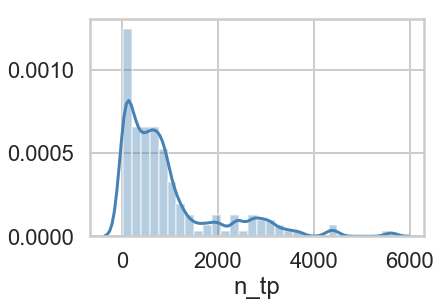

In [9]:
sns.distplot(net_data['n_tp'], bins=30, color='steelblue')

In [10]:
net_data.subj.nunique()

164

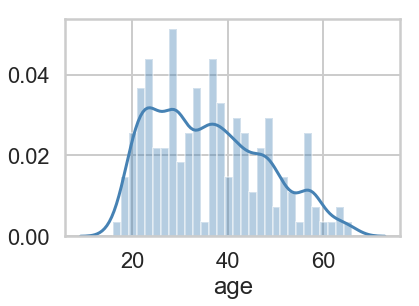

In [11]:
net_data['age'].replace(to_replace=0, value=None, inplace=True)
sns.distplot(net_data['age'].dropna(), bins=30, color='steelblue')
mean_age = net_data['age'].mean()

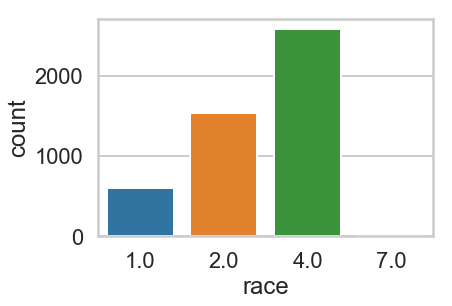

In [12]:
sns.countplot(data=net_data, x='race', )
mean_race = 4

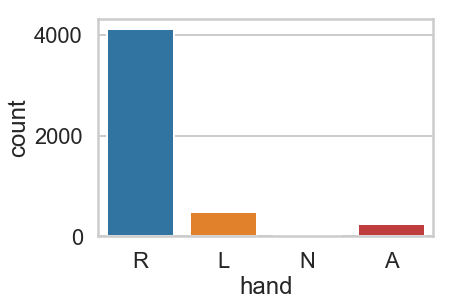

In [13]:
sns.countplot(data=net_data, x='hand', )
mean_hand = 'R'

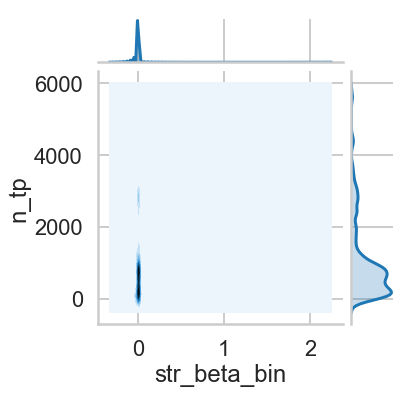

In [14]:
sns.jointplot(data=net_data, x='str_beta_bin', y='n_tp', kind='kde' )

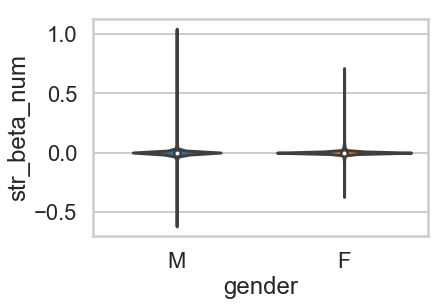

In [15]:
sns.violinplot(data=net_data, x='gender', y='str_beta_num', cut=True)

In [16]:
# add means for null values
net_data.loc[net_data['age'].isnull(), 'age'] = mean_age
net_data.loc[net_data['race'].isnull(), 'race'] = mean_race
net_data.loc[net_data['hand'].isnull(), 'hand'] = mean_hand

# same for node data
node_data.loc[node_data['age'].isnull(), 'age'] = mean_age
node_data.loc[node_data['race'].isnull(), 'race'] = mean_race
node_data.loc[node_data['hand'].isnull(), 'hand'] = mean_hand

In [17]:
# check for duplicates, these two numbers should match!!!
print(net_data[['str_beta_bin','subj']].dropna().subj.nunique())
print(net_data.loc[net_data.band_measure == 'theta_iplv',['str_beta_bin','subj']].dropna().subj.count())

146
146


In [18]:
# some subjects have ambidextrous and right handed answers in demographics, 
# take the one that is used in the net data (whatever they said first)
dems = ['race', 'hand', 'gender', 'age']
subjs = node_data['subj'].unique()
for s in subjs:
    if any(node_data.loc[node_data['subj'] == s, dems].nunique() > 1):
        correct_dems = net_data.loc[net_data.subj == s, dems]
        node_data.loc[node_data['subj'] == s, dems] = np.tile(correct_dems.iloc[0,:].values, 
                                                              (sum(node_data['subj'] == s),1))
node_data.drop(index=node_data.index[node_data.duplicated()], inplace=True)
node_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 491040 entries, 1 to 491040
Data columns (total 25 columns):
elec            491040 non-null object
band_measure    491040 non-null object
n_tp            491040 non-null int64
elec_spike      491040 non-null float64
elec_in_soz     491040 non-null int64
elec_in_ict     491040 non-null int64
ti_beta_bin     423420 non-null float64
ti_beta_num     472020 non-null float64
ti_beta_spr     472020 non-null float64
str_beta_spr    472020 non-null float64
str_beta_bin    423421 non-null float64
str_beta_num    472020 non-null float64
fc_measure      491040 non-null object
band            491040 non-null object
region          437100 non-null object
x               377850 non-null float64
y               377850 non-null float64
z               377850 non-null float64
type            491040 non-null object
wm              491040 non-null int64
subj            491040 non-null object
hand            491040 non-null object
age             491040 no

In [19]:
# drop nulls
cols = ['str_beta_bin','str_beta_num','str_beta_spr']

keep_subj = net_data.pivot_table(index='subj', columns=['fc_measure'],
                     values=['str_beta_bin','str_beta_num','str_beta_spr'], 
                                 aggfunc = lambda x: any(np.isnan(x))).any(axis=1)
keep_subj = keep_subj.index[[not x for x in keep_subj.values]]

net_data = net_data[[x in keep_subj for x in net_data.subj]]
node_data = node_data[[x in keep_subj for x in node_data.subj]]

In [20]:
net_data.subj.nunique()

145

## Effects on Network Measures

visualize how much spikes regularly change network strength.

In [21]:
# remove outliers 3 std
group_mean = net_data.groupby('band_measure').mean()
group_sd = net_data.groupby('band_measure').std()
bm = group_mean.index
col = group_mean.columns[1:-2]
for b in bm:
    for c in col:
        idx = (net_data['band_measure'] == b) & ((net_data.loc[:,c] > (group_mean.loc[b,c] + 3*group_sd.loc[b,c])) |
                                                 (net_data.loc[:,c] < (group_mean.loc[b,c] - 3*group_sd.loc[b,c])))
        net_data.loc[idx,c] = np.nan
net_data.head()

band_measure  n_tp  str_beta_bin  str_beta_num  str_beta_spr  \
30        alpha_aec    76     -0.017848     -0.038376      0.001960   
31  alpha_aec_ortho    76     -0.017813           NaN      0.001179   
32        alpha_coh    76           NaN           NaN     -0.003299   
33     alpha_im_coh    76           NaN           NaN     -0.003252   
34       alpha_iplv    76      0.001666      0.004304      0.000726   

    ti_beta_bin  ti_beta_num  ti_beta_spr  str_soz_beta_bin  str_soz_beta_num  \
30          NaN          NaN    -0.028822               NaN               NaN   
31          NaN          NaN     0.015400               NaN               NaN   
32          NaN          NaN     0.046141               NaN               NaN   
33          NaN    -0.365368    -0.002437               NaN               NaN   
34          NaN          NaN     0.015346               NaN               NaN   

    ...   str_gm_beta_bin  str_gm_beta_num  str_gm_beta_spr    subj  hand  \
30  ...               NaN              NaN              NaN  R1235E     L   
31  ...               NaN              NaN              NaN  R1235E     L   
32  ...         -0.037188              NaN         0.006574  R1235E     L   
33  ...         -0.009912        -0.030039         0.002696  R1235E     L   
34  ...         -0.006364        -0.012709         0.000768  R1235E     L   

     age  gender  race str_brid_beta_num  rate  
30  48.0       M   2.0               NaN   3.0  
31  48.0       M   2.0               NaN   3.0  
32  48.0       M   2.0               NaN   3.0  
33  48.0       M   2.0               NaN   3.0  
34  48.0       M   2.0               NaN   3.0  

[5 rows x 41 columns]

In [22]:
# save
# rename stuff to make it pretty
net_data.replace({'band':{'theta':'Theta', 'alpha':'Alpha','beta':'Beta', 'gamma':'Gamma',
                         'hg':'High Gamma', 'broadband':'LFP'}}, inplace=True)
net_data.rename(columns={'band':'Frequency Band', 'fc_measure':'Measure'}, inplace=True)
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_data_clean{detector}.csv')

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


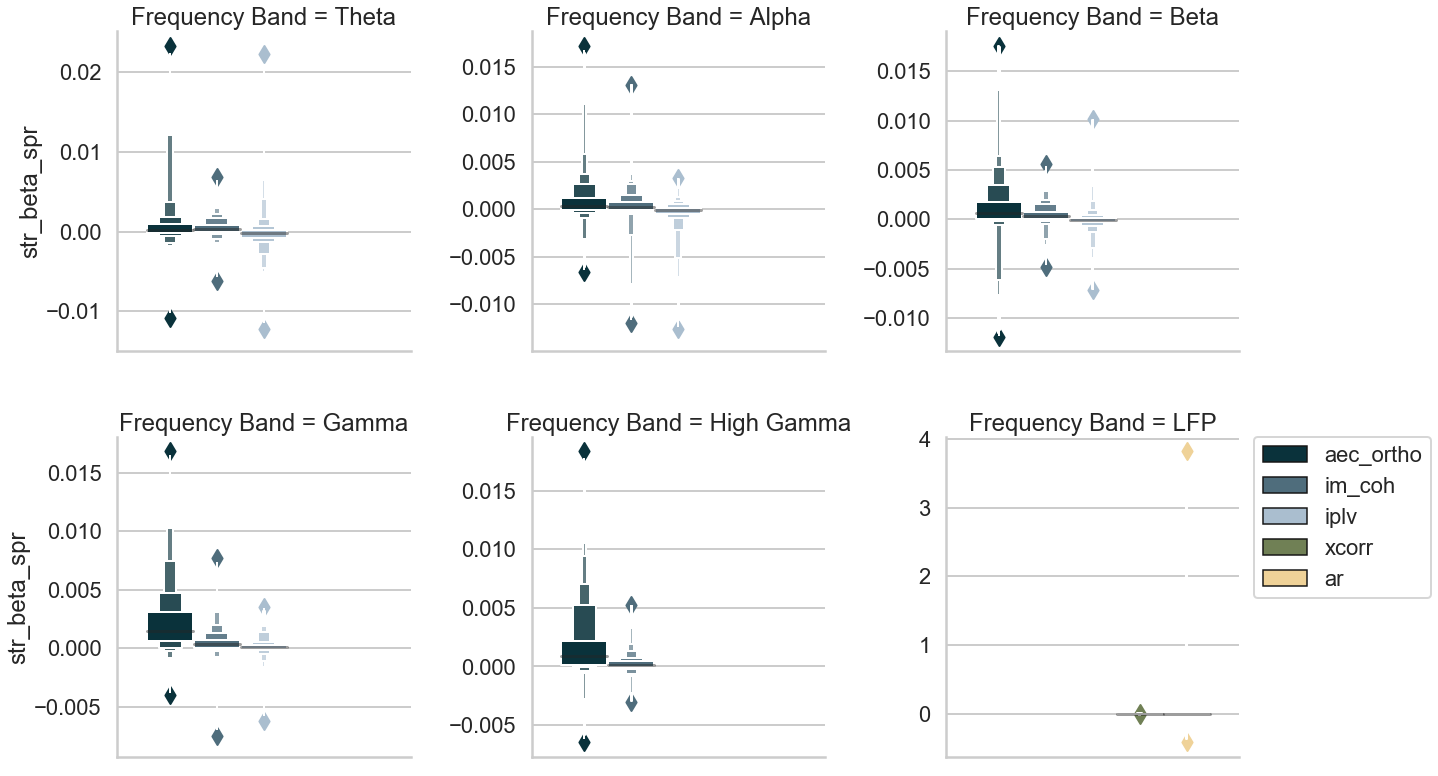

In [34]:
# parameters
supp_flag = True # if true, includes orthogonal AEC
yvar = 'spr'

if (not supp_flag):
    h_order = ['aec',  'coh', 'plv', 'xcorr', 'ar']
    supp_ext = ''
    # colors
    colors = ['#453947','#84476f', '#BB84C2', '#72874E', '#FED789']
    custom_palette = sns.set_palette(sns.color_palette(colors))
else:
    h_order = ['aec_ortho', 'im_coh', 'iplv', 'xcorr', 'ar']
    supp_ext = '_supp'
    # color pallette
    colors = ['#023743',  '#476f84', '#A4BED5', '#72874E', '#FED789']

    
g = sns.FacetGrid(data=net_data, col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=6, 
                 col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'])
g.map(sns.boxenplot, 'Frequency Band', 'str_beta_' + yvar, 'Measure', palette = sns.color_palette(colors), 
      hue_order=h_order)

g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
for ax in g.axes:
    ax.axes.xaxis.set_visible(False)
if (supp_flag):  
    g.savefig(f"../img/net_{yvar}_str{detector}_vc.eps")
else:
    g.savefig(f"../img/net_{yvar}_str{detector}.eps")

Is this because of volume conduction?

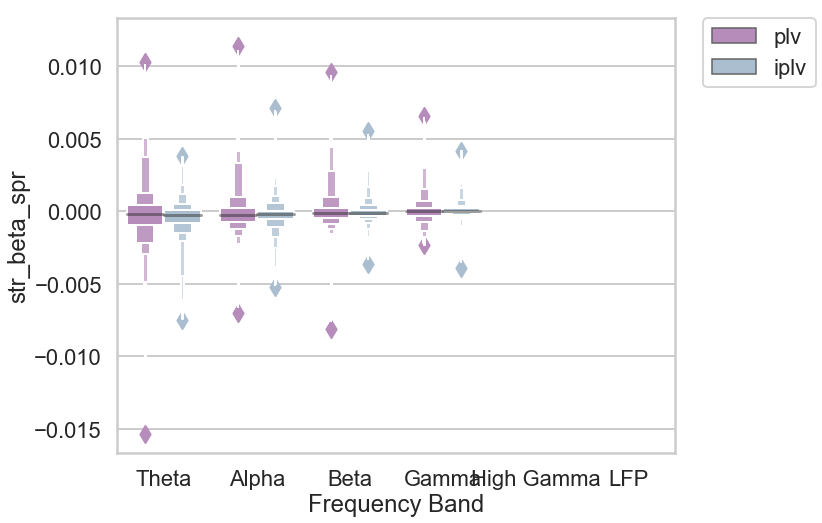

In [36]:

# parameters
y_var = 'spr'
m = 'plv'

if (m == 'coh'):
    h_order = ['coh', 'im_coh']
    # color pallette
    colors = ['#84476f', '#476f84']
elif (m=='aec'):
    h_order = ['aec', 'aec_ortho']
    colors = ['#453947', '#023732']
else:
    h_order = ['plv', 'iplv']
    colors = ['#BB84C2', '#A4BED5']
custom_palette = sns.set_palette(sns.color_palette(colors))

fig = plt.figure(figsize=(10,8))
sns.boxenplot( data=net_data[(net_data['Measure'] == h_order[0]) | (net_data['Measure'] == h_order[1])]
              , x="Frequency Band", y='str_beta_' + y_var, hue='Measure', 
            order=['Theta','Alpha','Beta','Gamma','High Gamma','LFP'], hue_order=h_order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.ylim(-2,2)
plt.savefig(f"../img/volume_conduction_{y_var}_{m}{detector}.eps")


### How does the avg IED rate correlate with changes in FC?

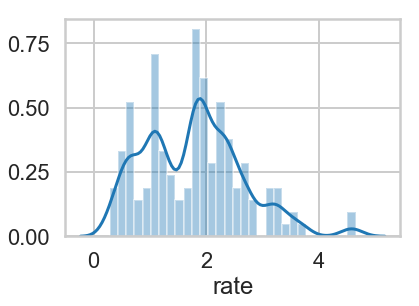

In [37]:
sns.distplot(np.log(net_data['rate']))
net_data['rate'] = np.log(net_data['rate'])

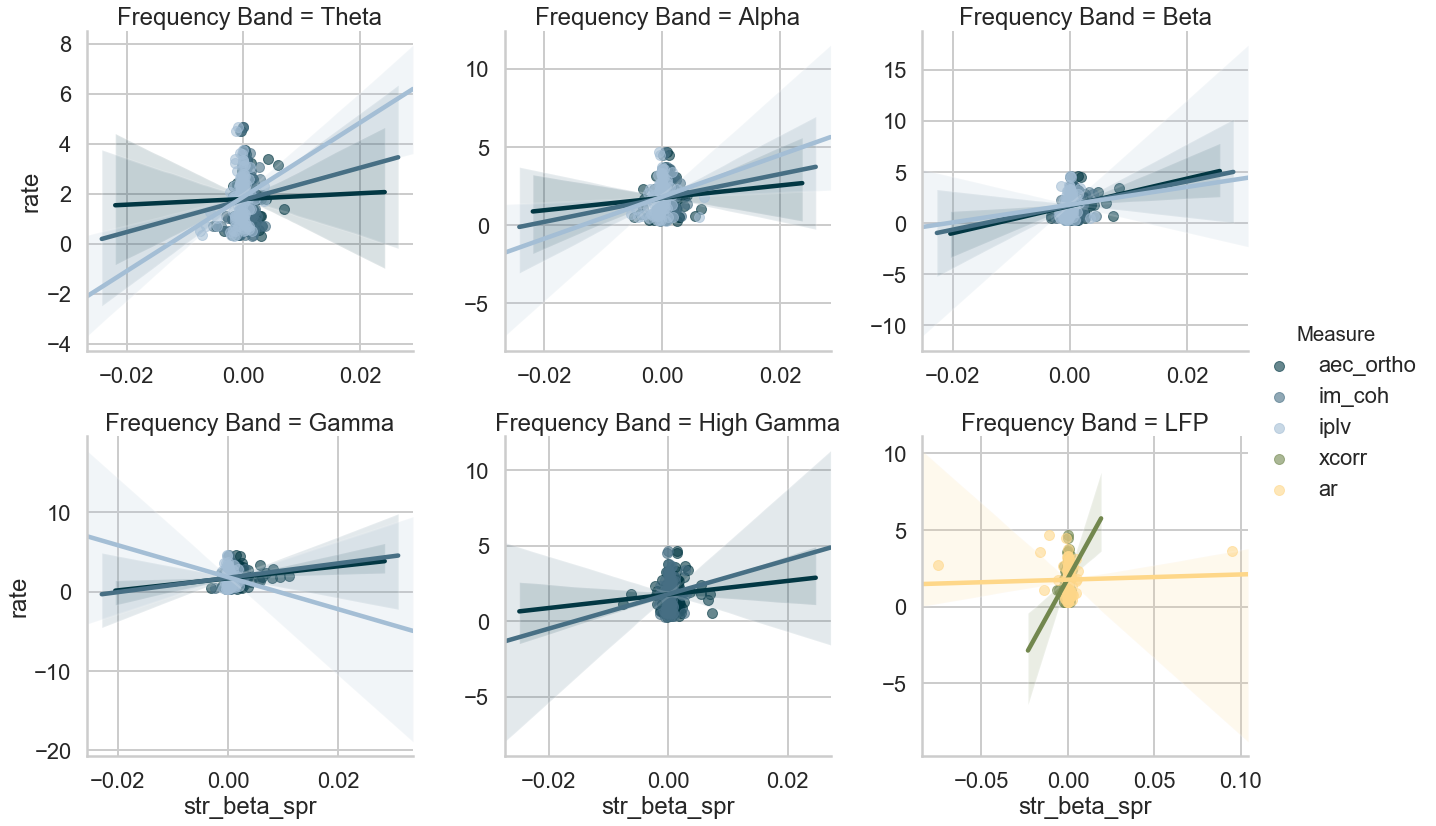

In [40]:
var = 'spr'
sns.lmplot(data=net_data, x='str_beta_' + var, y='rate', hue='Measure', col="Frequency Band", 
           col_wrap=3, height=6, sharex=False, sharey=False, 
           col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'],
           palette=sns.color_palette(colors), 
           scatter_kws={'s':100, 'alpha':.6}, 
           hue_order=h_order)
plt.savefig(f"../img/rate_{var}.pdf")

## How correlated changes in FC in response to different IED features?

We'll get pairwise correlations for  presence, number, and spread of IEDs

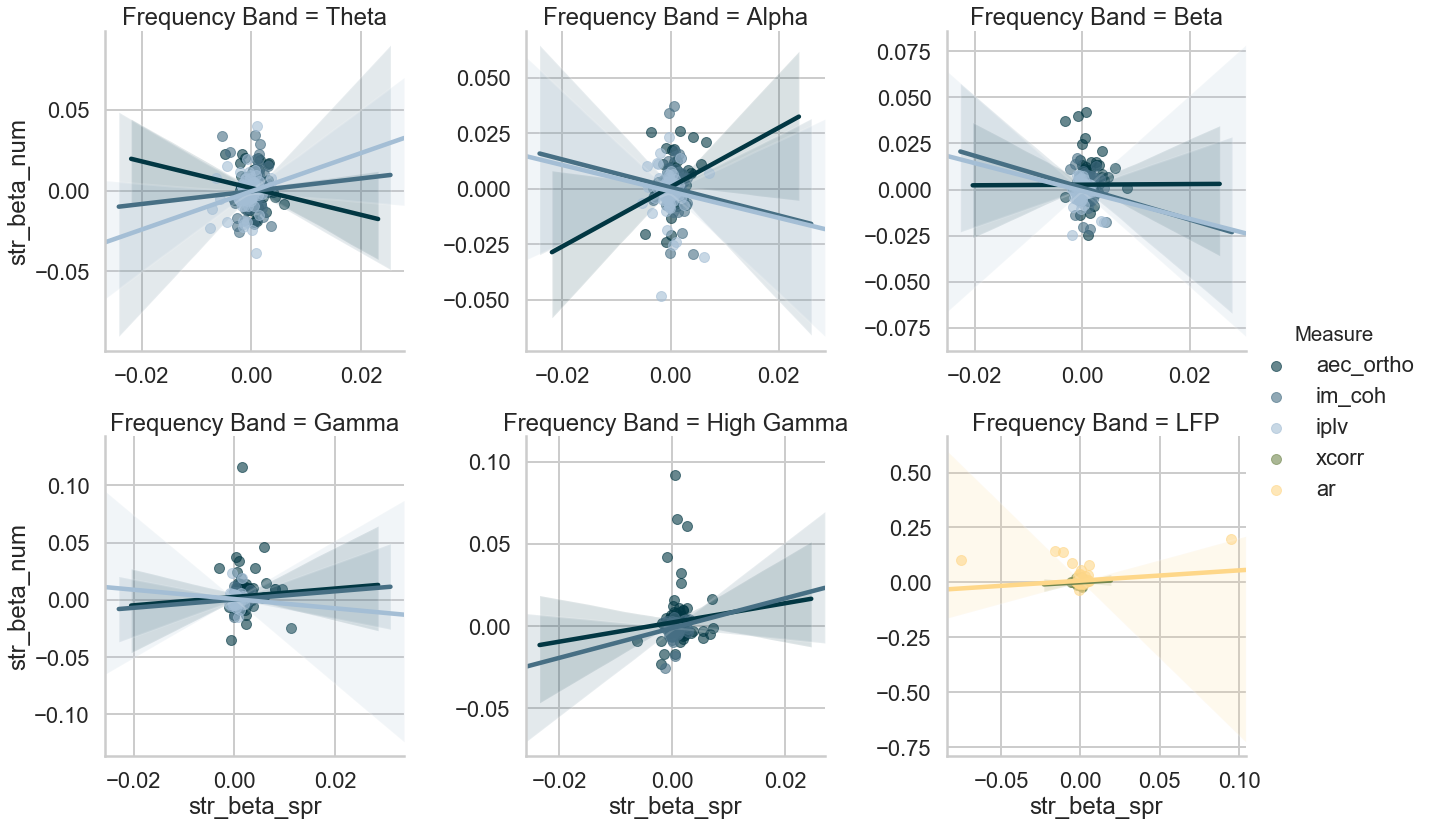

In [31]:
var1 = 'spr'
var2 = 'num'
sns.lmplot(data=net_data, x='str_beta_' + var1, y='str_beta_' + var2, hue='Measure', col="Frequency Band", 
           col_wrap=3, height=6, sharex=False, sharey=False, 
           col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'],
           palette=sns.color_palette(colors), 
           scatter_kws={'s':100, 'alpha':.6}, 
           hue_order=h_order)
plt.savefig(f"../img/{var1}_{var2}.pdf")

## Are changes similar within bands, or measures?

In [26]:
# initialize lists for later - need to keep trake of all predictors
null_data = pd.DataFrame(columns=['yvar', 'cors', 'type'])

y = []
label = []
rval = []
pval = []
ci_up = []
ci_lo = []


In [36]:
# get correlation matrix for all str effects
yvar = 'bin' 
net_data = net_data[(net_data['Measure'] != 'aec') & (net_data['Measure'] != 'coh') & (net_data['Measure'] != 'plv')]
net_data = net_data.assign(measure_band = net_data['Measure'] + '_' + net_data['Frequency Band'])
band_data = net_data.pivot_table(index = 'subj', columns='band_measure', 
                          values = ['str_beta_' + yvar]) # default agg func is mean
band_data.columns = [col[1] for col in band_data.columns]
cols = band_data.columns
cols = np.concatenate((cols[-3:].values, cols[:6].values, cols[8:-3].values, cols[6:8].values))
band_data = band_data[cols]
band_data.head()

theta_aec_ortho  theta_im_coh  theta_iplv  alpha_aec_ortho  \
subj                                                                 
R1001P         0.000523      0.000763    0.000817        -0.000180   
R1002P         0.001295      0.004785    0.002457        -0.000569   
R1003P        -0.000202      0.002789    0.001284        -0.000118   
R1004D              NaN           NaN    0.003072              NaN   
R1008J         0.006083      0.001252    0.001664        -0.000131   

        alpha_im_coh  alpha_iplv  beta_aec_ortho  beta_im_coh  beta_iplv  \
subj                                                                       
R1001P      0.000045   -0.000972        0.001077     0.000230  -0.000757   
R1002P      0.002074    0.000155        0.002119     0.001555  -0.001162   
R1003P      0.000807   -0.001237        0.000407     0.000425  -0.000754   
R1004D           NaN    0.017330        0.036678          NaN   0.013981   
R1008J      0.001739    0.001258        0.000752     0.000594  -0.000261   

        gamma_aec_ortho  gamma_im_coh  gamma_iplv  hg_aec_ortho  hg_im_coh  \
subj                                                                         
R1001P         0.000856      0.000375   -0.000064      0.000626   0.000574   
R1002P         0.004203      0.001425    0.000677      0.004770   0.001192   
R1003P         0.002247     -0.000215    0.000264      0.000077  -0.000405   
R1004D         0.023132           NaN         NaN     -0.015638   0.006422   
R1008J        -0.000092     -0.000896    0.000295     -0.000509  -0.001234   

        broadband_ar  broadband_xcorr  
subj                                   
R1001P      0.003431        -0.004424  
R1002P     -0.000553         0.003471  
R1003P      0.000710        -0.002121  
R1004D      0.002040         0.000201  
R1008J     -0.000328        -0.001104

In [37]:
meas_data = net_data.pivot_table(index = 'subj', columns='measure_band', 
                                 values = ['str_beta_' + yvar])
meas_data.columns = [col[1] for col in meas_data.columns]
cols = meas_data.columns
cols = np.concatenate((cols[4:-11].values, cols[0:4].values, cols[10:-5].values, cols[6:10].values, 
                       cols[14:15].values, cols[11:14].values, cols[15:16].values, cols[5:-10].values))
meas_data = meas_data[cols]
meas_data.head()

aec_ortho_Theta  aec_ortho_Alpha  aec_ortho_Beta  aec_ortho_Gamma  \
subj                                                                        
R1001P         0.000523        -0.000180        0.001077         0.000856   
R1002P         0.001295        -0.000569        0.002119         0.004203   
R1003P        -0.000202        -0.000118        0.000407         0.002247   
R1004D              NaN              NaN        0.036678         0.023132   
R1008J         0.006083        -0.000131        0.000752        -0.000092   

        aec_ortho_High Gamma  im_coh_Theta  im_coh_Alpha  im_coh_Beta  \
subj                                                                    
R1001P              0.000626      0.000763      0.000045     0.000230   
R1002P              0.004770      0.004785      0.002074     0.001555   
R1003P              0.000077      0.002789      0.000807     0.000425   
R1004D             -0.015638           NaN           NaN          NaN   
R1008J             -0.000509      0.001252      0.001739     0.000594   

        im_coh_Gamma  im_coh_High Gamma  iplv_Theta  iplv_Alpha  iplv_Beta  \
subj                                                                         
R1001P      0.000375           0.000574    0.000817   -0.000972  -0.000757   
R1002P      0.001425           0.001192    0.002457    0.000155  -0.001162   
R1003P     -0.000215          -0.000405    0.001284   -0.001237  -0.000754   
R1004D           NaN           0.006422    0.003072    0.017330   0.013981   
R1008J     -0.000896          -0.001234    0.001664    0.001258  -0.000261   

        iplv_Gamma  xcorr_LFP    ar_LFP  
subj                                     
R1001P   -0.000064  -0.004424  0.003431  
R1002P    0.000677   0.003471 -0.000553  
R1003P    0.000264  -0.002121  0.000710  
R1004D         NaN   0.000201  0.002040  
R1008J    0.000295  -0.001104 -0.000328

In [38]:
# ordered by subj corr map
sim_metric = 'corr' # correlation or euclidean distance
if sim_metric == 'corr':
    band_rsm = band_data.corr(method='spearman')
    meas_rsm = meas_data.corr(method='spearman')
    # remove diagonal
    band_rsm[band_rsm == 1] = np.nan
    meas_rsm[meas_rsm==1] = np.nan
else:
    band_rsm = euclidean_distances(band_data)
    meas_rsm = euclidean_distances(meas_data)


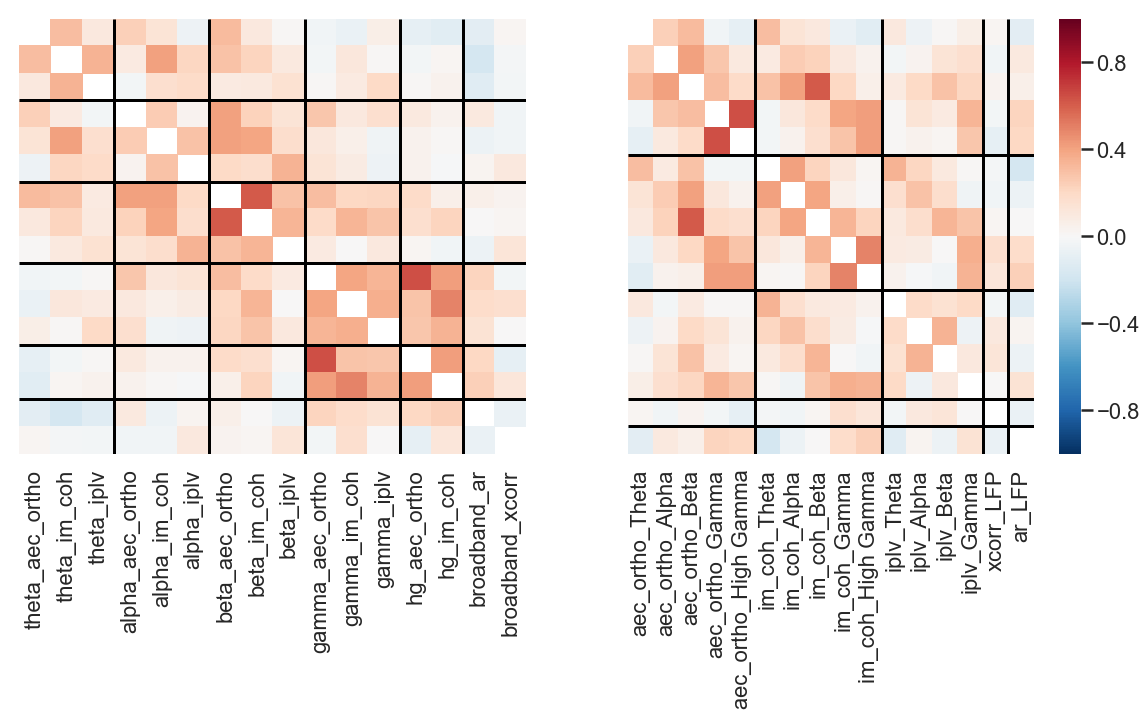

In [39]:
fig, axes = plt.subplots(1,2, figsize=(20,8))
sns.heatmap(band_rsm, xticklabels=True, yticklabels=False, cmap ='RdBu_r',  cbar=False, ax=axes[0],
           vmin=-1, vmax=1)
axes[0].hlines([3,6,9,12,14], xmin=0, xmax=16)
axes[0].vlines([3,6,9,12,14],0,16)
sns.heatmap(meas_rsm, xticklabels=True, yticklabels=False, cmap='RdBu_r', cbar=True, ax=axes[1],
           vmin=-1, vmax=1)
axes[1].hlines([5,10,14,15],0,16)
axes[1].vlines([5,10,14,15],0,16)
plt.savefig(f'../img/band_meas_sim_{yvar}.pdf')

In [40]:
band_within = np.zeros(np.shape(band_rsm))
meas_within = np.zeros(np.shape(band_rsm))
group_within = np.zeros(np.shape(band_rsm))

band_cols = [x.split('_')[0] for x in band_rsm.columns]
meas_cols = [x.split('_')[0] for x in meas_rsm.columns]
band_rows = [x.split('_')[0] for x in band_rsm.index]
meas_rows = [x.split('_')[0] for x in meas_rsm.index]
for b in np.unique(band_rows):
    band_within[np.where([x == b for x in band_rows])[0][0]:(np.where([x == b for x in band_rows])[0][-1] + 1),
                np.where([x == b for x in band_cols])[0][0]:(np.where([x == b for x in band_cols])[0][-1] + 1)] = 1
for m in np.unique(meas_rows):
    meas_within[np.where([x == m for x in meas_rows])[0][0]:(np.where([x == m for x in meas_rows])[0][-1] + 1),
                np.where([x == m for x in meas_cols])[0][0]:(np.where([x == m for x in meas_cols])[0][-1] + 1)] = 1
    
# frequency bands
groups = [['theta','alpha', 'beta'],['gamma','hg']]
for g in groups:
    group_within[np.where([x in g for x in band_rows])[0][0]:(np.where([x in g for x in band_rows])[0][-1] + 1),
                np.where([x in g for x in band_cols])[0][0]:(np.where([x in g for x in band_cols])[0][-1] + 1)] = 1

    

In [41]:
# repeat for null values
def shuffle_label(data, n):
    subj = data['subj'].unique()
    nSubj = data['subj'].nunique()
    data['band_meas_new'] = data['band_measure']
    data['meas_band_new'] = data['measure_band']
    idx = np.arange(n)
    np.random.shuffle(idx)
    for i in range(nSubj):
        
        data.loc[data['subj'] == subj[i], 'band_meas_new'] = data.loc[data['subj'] == subj[i], 'band_meas_new'].values[idx]
        data.loc[data['subj'] == subj[i], 'meas_band_new'] = data.loc[data['subj'] == subj[i], 'meas_band_new'].values[idx]

nSim = 100
null_band_rsm = []
null_meas_rsm = []
null_tilt_rsm = []
for i in range(nSim):
    # shuffle
    order = net_data.groupby(['subj','band_measure', 'measure_band']).mean().reset_index()[['subj', 'band_measure', 'measure_band']]
    shuffle_label(order, order['band_measure'].nunique())

    curr = net_data[['subj', 'band_measure', 'measure_band', 'str_beta_' + yvar]]
    curr = curr.merge(order, how='right', on=['subj', 'band_measure', 'measure_band'])

    # format
    band_data = curr.pivot_table(index = 'subj', columns='band_meas_new', 
                          values = ['str_beta_' + yvar]) # default agg func is mean
    band_data.columns = [col[1] for col in band_data.columns]
    cols = band_data.columns
    cols = np.concatenate((cols[-3:].values, cols[:13].values))
    band_data = band_data[cols]


    # measure 
    #format
    meas_data = curr.pivot_table(index = 'subj', columns='meas_band_new', 
                                 values = ['str_beta_' + yvar])
    meas_data.columns = [col[1] for col in meas_data.columns]
    cols = meas_data.columns
    cols = np.concatenate((cols[4:-11].values, cols[0:4].values, cols[10:-5].values, cols[6:10].values, 
                       cols[14:15].values, cols[11:14].values, cols[15:16].values, cols[5:-10].values))
    meas_data = meas_data[cols]


    # get sim matrix
    tmp_band = band_data.corr(method='spearman')
    tmp_meas = meas_data.corr(method='spearman')
    tmp_band = tmp_band.values
    tmp_meas = tmp_meas.values

    # vectorize and correlate with mask
    [r,p] = sp.stats.pearsonr(band_within[np.triu_indices(np.size(band_cols),1)],
                 tmp_band[np.triu_indices(np.size(band_cols),1)])
    null_band_rsm.append(r)
    [r,p] = sp.stats.pearsonr(meas_within[np.triu_indices(np.size(band_cols),1)],
                 tmp_meas[np.triu_indices(np.size(band_cols),1)])
    null_meas_rsm.append(r)
    [r,p] = sp.stats.pearsonr(group_within[np.triu_indices(np.size(band_cols),1)],
                 tmp_band[np.triu_indices(np.size(band_cols),1)])
    null_tilt_rsm.append(r)

null_data = pd.merge(null_data, pd.DataFrame({'yvar':yvar, 
              'cors':list(itertools.chain.from_iterable([null_band_rsm,null_meas_rsm, null_tilt_rsm])),
              'type':list(itertools.chain.from_iterable([['band']*len(null_band_rsm), ['meas']*len(null_meas_rsm), ['tilt']*len(null_tilt_rsm)]))}),
               on=['yvar', 'cors', 'type'], how='outer')

In [42]:
# within band
band_test = band_rsm.values

[r,p] = sp.stats.pearsonr(band_within[np.triu_indices(np.size(band_cols),1)],
                 band_test[np.triu_indices(np.size(band_cols),1)])
print([r])

# get ci
r_z = np.arctanh(r)
se = 1/np.sqrt(np.size(band_test[np.triu_indices(np.size(band_cols),1)]) - 3)
alpha = 0.05
z = sp.stats.norm.ppf(1-alpha/2)
lo, hi = np.tanh(r_z-z*se), np.tanh(r_z+z*se)

y.append(yvar)
rval.append(r)
pval.append(p)
ci_up.append(hi)
ci_lo.append(lo)
label.append('band')


[0.3460813086984047]


In [43]:
# within measure
meas_test = meas_rsm.values
[r,p] = sp.stats.pearsonr(meas_within[np.triu_indices(np.size(band_cols),1)],
                 meas_test[np.triu_indices(np.size(band_cols),1)])
print([r])

# get ci
r_z = np.arctanh(r)
se = 1/np.sqrt(np.size(band_test[np.triu_indices(np.size(band_cols),1)]) - 3)
alpha = 0.05
z = sp.stats.norm.ppf(1-alpha/2)
lo, hi = np.tanh(r_z-z*se), np.tanh(r_z+z*se)

y.append(yvar)
rval.append(r)
pval.append(p)
ci_up.append(hi)
ci_lo.append(lo)
label.append('meas')

[0.25938165106504213]


In [44]:
# within tilt group
[r,p] = sp.stats.pearsonr(group_within[np.triu_indices(np.size(band_cols),1)],
                 band_test[np.triu_indices(np.size(band_cols),1)])
print([r])


# get ci
r_z = np.arctanh(r)
se = 1/np.sqrt(np.size(band_test[np.triu_indices(np.size(band_cols),1)]) - 3)
alpha = 0.05
z = sp.stats.norm.ppf(1-alpha/2)
lo, hi = np.tanh(r_z-z*se), np.tanh(r_z+z*se)

y.append(yvar)
rval.append(r)
pval.append(p)
ci_up.append(hi)
ci_lo.append(lo)
label.append('tilt')

[0.5937981254466297]


In [51]:
def grouped_barplot(df, cat,subcat, val , err,c,saveas):
    u = df[cat].unique()
    x = np.arange(len(u))
    subx = df[subcat].unique()
    offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
    width= np.diff(offsets).mean()
    for i,gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        plt.bar(x+offsets[i], dfg[val].values, width=width, 
                label="{} {}".format(subcat, gr), yerr=dfg[err].values, color=c[i])
    plt.xlabel(cat)
    plt.ylabel(val)
    plt.xticks(x, u)
    plt.legend()
    plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)
    #plt.show()
    plt.savefig(saveas)

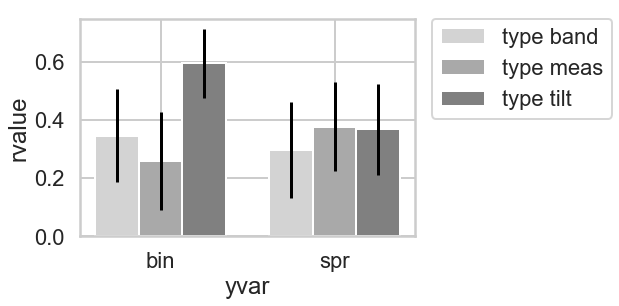

In [52]:
group_sim = pd.DataFrame({'yvar':y,'type':label,'rvalue':rval,'pvalue':pval, 
                          'err':(np.array(ci_up) - np.array(ci_lo))/2})
grouped_barplot(group_sim, 'yvar', 'type', 'rvalue', 'err', 
                ['lightgrey','darkgrey','grey','lightgrey','darkgrey','grey'], f"../img/band_meas_sim2.pdf")


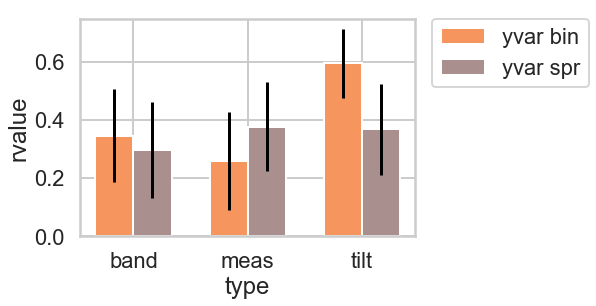

In [53]:
colors = ['#F6955E', '#A98F8E','#F6955E', '#A98F8E','#F6955E', '#A98F8E']
group_sim = pd.DataFrame({'yvar':y,'type':label,'rvalue':rval,'pvalue':pval, 
                          'err':(np.array(ci_up) - np.array(ci_lo))/2})
grouped_barplot(group_sim, 'type', 'yvar', 'rvalue', 'err',colors,f"../img/band_meas_sim.pdf" )


0
0
0
0
0
0


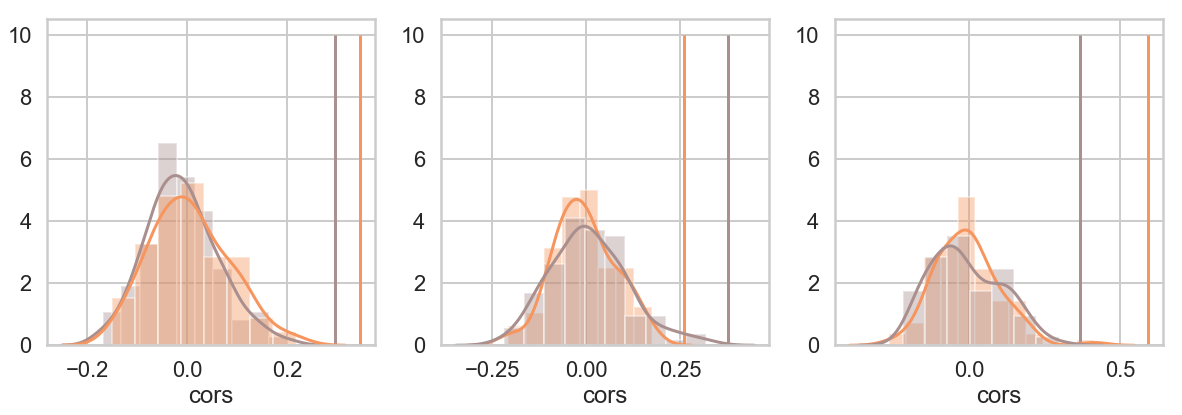

In [54]:
# plot null data. printed values are the number of permuted models more smilar than the true data
fig, ax = plt.subplots(1,3, figsize=(20,6))
print(sum(null_data.loc[(null_data['yvar']=='spr') & (null_data['type']=='band'), 'cors'].values > 
    group_sim.loc[(group_sim['yvar']=='spr') & (group_sim['type'] == 'band'),'rvalue'].values))
print(sum(null_data.loc[(null_data['yvar']=='bin') & (null_data['type']=='band'), 'cors'].values > 
    group_sim.loc[(group_sim['yvar']=='bin') & (group_sim['type'] == 'band'),'rvalue'].values))
sns.distplot(null_data.loc[(null_data['yvar']=='spr') & (null_data['type']=='band'), 'cors'], color= '#A98F8E', ax=ax[0])
sns.distplot(null_data.loc[(null_data['yvar']=='bin') & (null_data['type']=='band'),'cors'],color='#F6955E',ax=ax[0])
ax[0].vlines(group_sim.loc[(group_sim['yvar']=='spr') & (group_sim['type'] == 'band'),'rvalue'], 0, 10, color= '#A98F8E')
ax[0].vlines(group_sim.loc[(group_sim['yvar']=='bin') & (group_sim['type'] == 'band'), 'rvalue'], 0, 10, color='#F6955E')

print(sum(null_data.loc[(null_data['yvar']=='spr') & (null_data['type']=='meas'), 'cors'].values > 
    group_sim.loc[(group_sim['yvar']=='spr') & (group_sim['type'] == 'meas'),'rvalue'].values))
print(sum(null_data.loc[(null_data['yvar']=='bin') & (null_data['type']=='meas'), 'cors'].values > 
    group_sim.loc[(group_sim['yvar']=='bin') & (group_sim['type'] == 'meas'),'rvalue'].values))
sns.distplot(null_data.loc[(null_data['yvar']=='bin') & (null_data['type']=='meas'), 'cors'], color='#F6955E', ax=ax[1])
sns.distplot(null_data.loc[(null_data['yvar']=='spr') & (null_data['type']=='meas'),'cors'],color= '#A98F8E',ax=ax[1])
ax[1].vlines(group_sim.loc[(group_sim['yvar']=='bin') & (group_sim['type'] == 'meas'),'rvalue'], 0, 10, color='#F6955E')
ax[1].vlines(group_sim.loc[(group_sim['yvar']=='spr') & (group_sim['type'] == 'meas'), 'rvalue'], 0,10, color= '#A98F8E')

print(sum(null_data.loc[(null_data['yvar']=='spr') & (null_data['type']=='tilt'), 'cors'].values > 
    group_sim.loc[(group_sim['yvar']=='spr') & (group_sim['type'] == 'tilt'),'rvalue'].values))
print(sum(null_data.loc[(null_data['yvar']=='bin') & (null_data['type']=='tilt'), 'cors'].values > 
    group_sim.loc[(group_sim['yvar']=='bin') & (group_sim['type'] == 'tilt'),'rvalue'].values))
sns.distplot(null_data.loc[(null_data['yvar']=='bin') & (null_data['type']=='tilt'), 'cors'], color='#F6955E', ax=ax[2])
sns.distplot(null_data.loc[(null_data['yvar']=='spr') & (null_data['type']=='tilt'),'cors'],color= '#A98F8E',ax=ax[2])
ax[2].vlines(group_sim.loc[(group_sim['yvar']=='bin') & (group_sim['type'] == 'tilt'),'rvalue'], 0, 10, color='#F6955E')
ax[2].vlines(group_sim.loc[(group_sim['yvar']=='spr') & (group_sim['type'] == 'tilt'), 'rvalue'], 0,10, color= '#A98F8E')
plt.savefig(f'../img/perm_test_sim.pdf')

## Are effects driven by certain edge subsets?
First, SOZ edges

In [55]:
# add difference for plotting
net_data = net_data.assign(soz_diff_num = net_data['str_soz_beta_num'] - net_data['str_not_soz_beta_num'], 
                           soz_diff_bin = net_data['str_soz_beta_bin'] - net_data['str_not_soz_beta_bin'],
                           soz_diff_spr = net_data['str_soz_beta_spr'] - net_data['str_not_soz_beta_spr'])

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


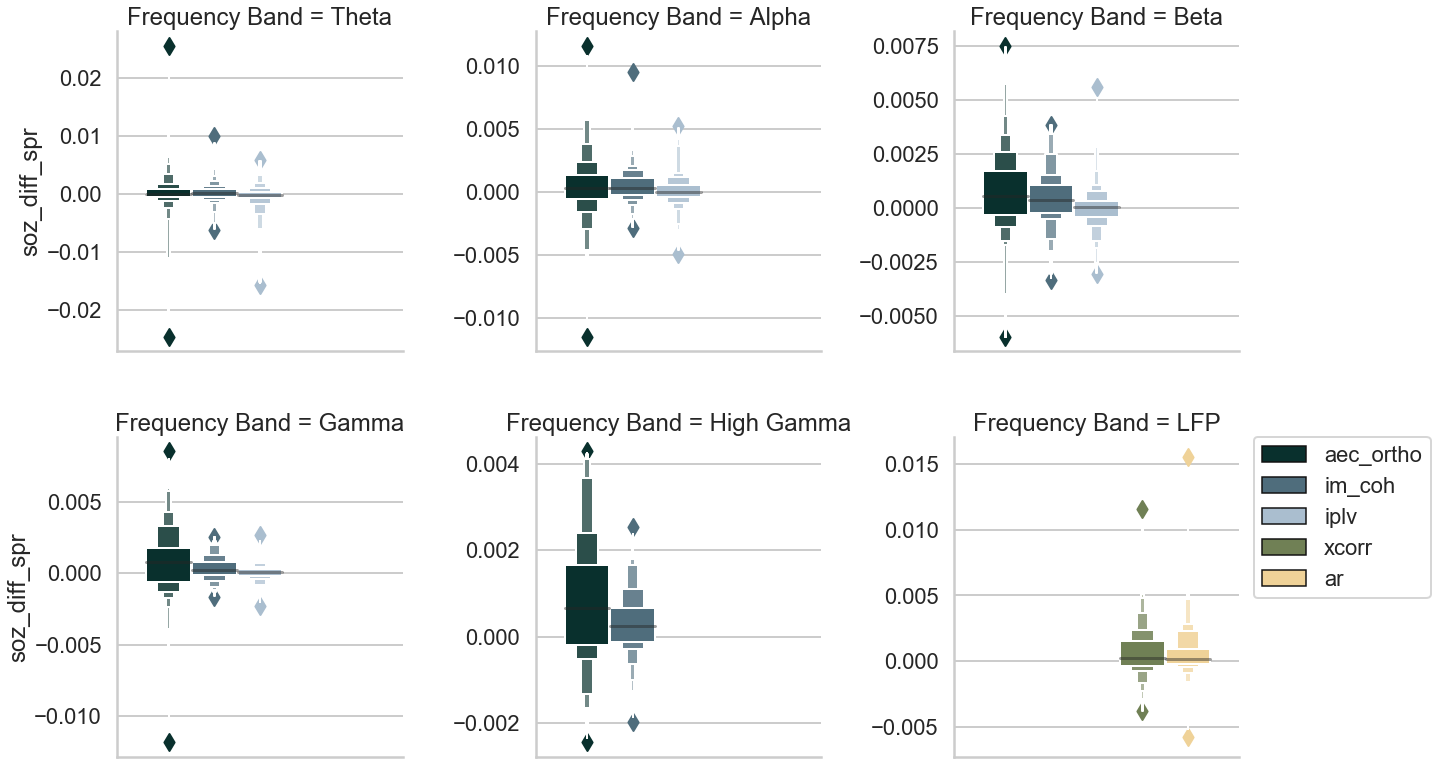

In [58]:
yvar = 'spr'

colors = ['#023732', '#476f84', '#a4bed5', '#72874e', '#fed789']
h_order = ['aec_ortho', 'im_coh', 'iplv', 'xcorr', 'ar']

g = sns.FacetGrid(data=net_data, col='Frequency Band', col_wrap=3, sharex=False, sharey=False, height=6,
                 col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'])
g.map(sns.boxenplot, "Frequency Band", "soz_diff_" + yvar, "Measure",
             hue_order = h_order,  palette=sns.color_palette(colors))
g.axes[5].legend(bbox_to_anchor=(1.05,1), loc=2,borderaxespad=0.)
for ax in g.axes:
    ax.axes.xaxis.set_visible(False)

g.savefig(f"../img/net_soz_{yvar}{detector}.eps")

In [59]:
# save
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_soz_data_clean{detector}.csv')

Repeat for spikes

In [60]:
# add difference for plotting
net_data = net_data.assign(spike_diff_num = net_data['str_spike_beta_num'] - net_data['str_not_spike_beta_num'], 
                           spike_diff_bin = net_data['str_spike_beta_bin'] - net_data['str_not_spike_beta_bin'],
                          spike_diff_spr = net_data['str_spike_beta_spr'] - net_data['str_not_spike_beta_spr'])

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


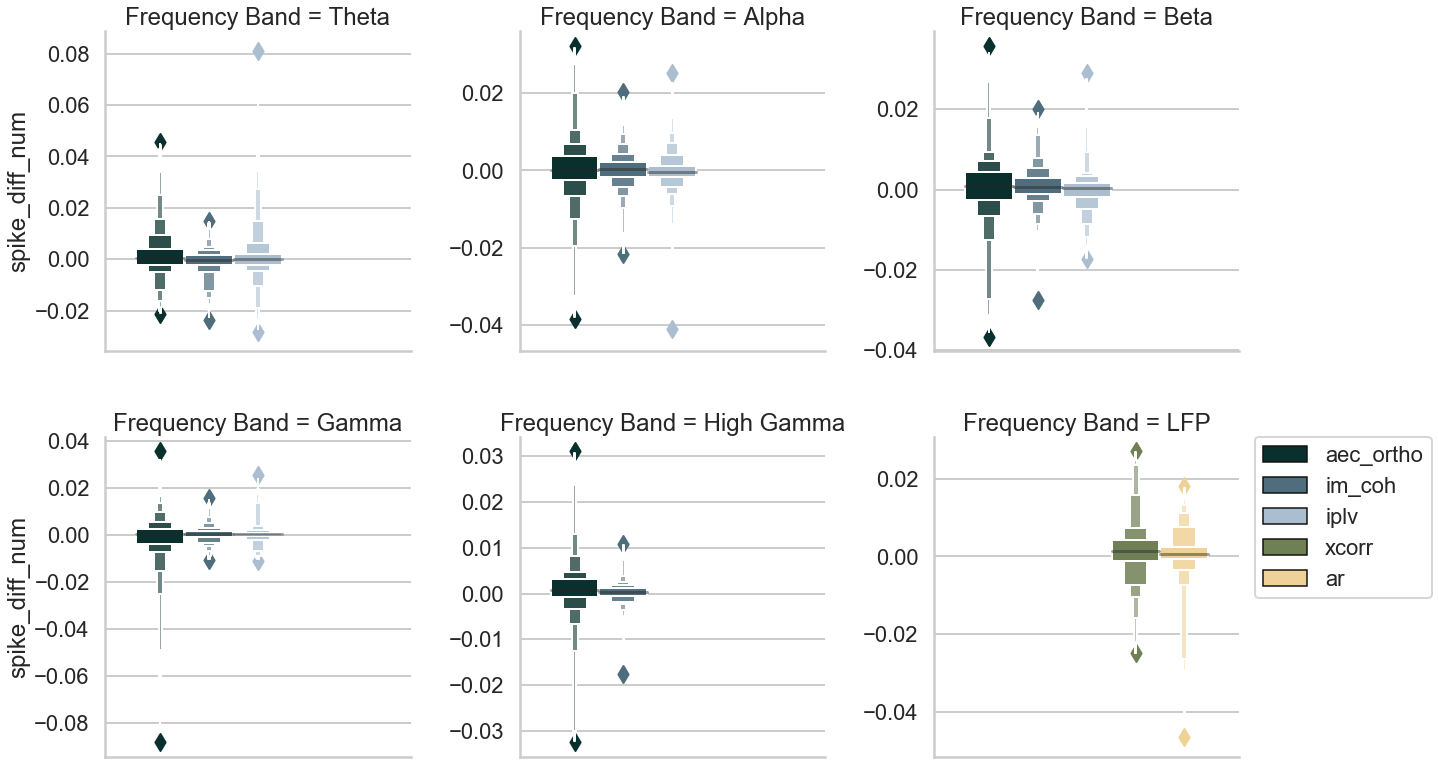

In [63]:
yvar = 'num'

colors = ['#023732', '#476f84', '#a4bed5', '#72874e', '#fed789']
h_order = ['aec_ortho', 'im_coh', 'iplv', 'xcorr', 'ar']

g=sns.FacetGrid(data=net_data, col="Frequency Band", col_wrap=3, col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'],
                sharex=False, sharey=False, height=6)
g.map(sns.boxenplot, "Frequency Band", "spike_diff_" + yvar, "Measure",
             hue_order = h_order, palette=sns.color_palette(colors))
g.axes[5].legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)
for a in g.axes:
    a.axes.xaxis.set_visible(False)
g.savefig(f"../img/net_spike_{yvar}{detector}.eps")

In [64]:
# save
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_spike_data_clean{detector}.csv')

Now for skew

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


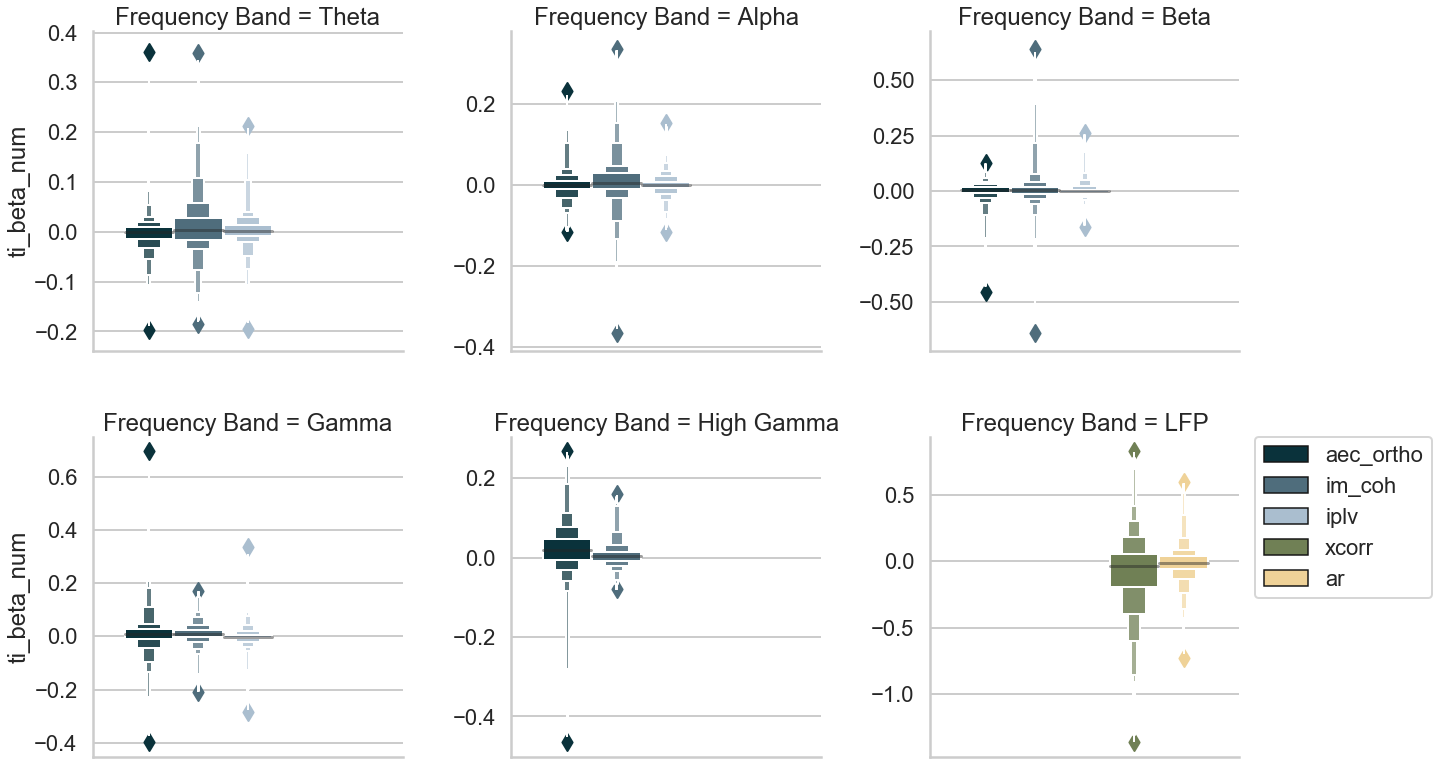

In [28]:
# parameters
supp_flag = True # if true, includes orthogonal AEC
yvar = 'num'

if (not supp_flag):
    h_order = ['aec',  'coh', 'plv', 'xcorr', 'ar']
    supp_ext = ''
    # colors
    colors = ['#453947','#84476f', '#BB84C2', '#72874E', '#FED789']
    custom_palette = sns.set_palette(sns.color_palette(colors))
else:
    h_order = ['aec_ortho', 'im_coh', 'iplv', 'xcorr', 'ar']
    supp_ext = '_supp'
    # color pallette
    colors = ['#023743',  '#476f84', '#A4BED5', '#72874E', '#FED789']

    
g = sns.FacetGrid(data=net_data, col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=6, 
                 col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'])
g.map(sns.boxenplot, 'Frequency Band', 'ti_beta_' + yvar, 'Measure', palette = sns.color_palette(colors), 
      hue_order=h_order)

g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
for ax in g.axes:
    ax.axes.xaxis.set_visible(False)
if (supp_flag):  
    g.savefig(f"../img/net_{yvar}_ti{detector}_vc.eps")
else:
    g.savefig(f"../img/net_{yvar}_ti{detector}.eps")

## Which explains more variance? Coverage, or individual?

In [65]:
# remove outliers 3 std for node data
group_mean = node_data.groupby(['band_measure', 'subj']).mean()
group_sd = node_data.groupby(['band_measure', 'subj']).std()*3
bm = group_mean.index
col = group_mean.columns[1:-2]
for b in bm:
    for c in col:
        idx = (node_data['band_measure'] == b[0]) & (node_data['subj'] == b[1]) & ((node_data.loc[:,c] > (group_mean.loc[b,c] + group_sd.loc[b,c])) | 
        node_data.loc[:,c] < (group_mean.loc[b,c] - group_sd.loc[b,c]))
        node_data.loc[idx,c] = np.nan
node_data.head()

elec     band_measure  n_tp  elec_spike  elec_in_soz  elec_in_ict  \
3661  x10RD1        alpha_aec    76         0.0          0.0          0.0   
3662  x10RD1  alpha_aec_ortho    76         0.0          0.0          0.0   
3663  x10RD1        alpha_coh    76         0.0          0.0          0.0   
3664  x10RD1     alpha_im_coh    76         0.0          0.0          0.0   
3665  x10RD1       alpha_iplv    76         0.0          0.0          0.0   

      ti_beta_bin  ti_beta_num  ti_beta_spr  str_beta_spr  ...         x  \
3661     0.890522     2.059203    -0.103388     -0.009051  ...  -7.23845   
3662    -0.959872    -2.380283     0.103819     -0.010654  ...  -7.23845   
3663    -3.046442    -6.917871     0.276248      0.002311  ...  -7.23845   
3664    -1.702295    -4.071393     0.159484     -0.005212  ...  -7.23845   
3665    -3.963505    -9.364361     0.413855     -0.039241  ...  -7.23845   

            y          z type   wm    subj  hand   age gender  race  
3661  68.1148 -11.365091    S  0.0  R1235E     L  48.0      M   2.0  
3662  68.1148 -11.365091    S  0.0  R1235E     L  48.0      M   2.0  
3663  68.1148 -11.365091    S  0.0  R1235E     L  48.0      M   2.0  
3664  68.1148 -11.365091    S  0.0  R1235E     L  48.0      M   2.0  
3665  68.1148 -11.365091    S  0.0  R1235E     L  48.0      M   2.0  

[5 rows x 25 columns]

In [66]:
# get correlation matrix for all str effects
# thi subj has duplicates...unclear why
node_data = node_data[node_data['subj'] != 'R1232N']
sim_data = node_data[['subj', 'region', 'str_beta_bin', 'str_beta_num', 'str_beta_spr', 'band_measure']]
sim_data = sim_data.assign(unique_id = sim_data['subj'] + '_' + sim_data['region'], 
                           reg_id = sim_data['region'] + '_' + sim_data['subj'])
subj_data = sim_data.pivot_table(index = 'unique_id', columns='band_measure', 
                          values = ['str_beta_bin', 'str_beta_num', 'str_beta_spr']) # default agg func is mean
subj_data.head()

str_beta_bin                                         \
band_measure               alpha_aec alpha_aec_ortho alpha_coh alpha_im_coh   
unique_id                                                                     
R1001P_fusiform            -0.002525       -0.002060 -0.000574    -0.000482   
R1001P_inferiortemporal    -0.002935       -0.002855  0.000067    -0.000069   
R1001P_lateraloccipital    -0.002296       -0.001429 -0.000732    -0.001176   
R1001P_lingual             -0.004350       -0.001302 -0.001229    -0.001270   
R1001P_middletemporal      -0.001627       -0.002295 -0.000385    -0.000269   

                                                                       \
band_measure            alpha_iplv alpha_plv  beta_aec beta_aec_ortho   
unique_id                                                               
R1001P_fusiform          -0.000837 -0.000305  0.002808       0.000913   
R1001P_inferiortemporal  -0.000599 -0.000344 -0.000039      -0.000018   
R1001P_lateraloccipital  -0.003465 -0.002843  0.001363       0.001536   
R1001P_lingual           -0.000434 -0.000792  0.000378       0.000531   
R1001P_middletemporal    -0.002245 -0.000704 -0.000239      -0.002384   

                                                 ...    str_beta_spr  \
band_measure             beta_coh beta_im_coh    ...          hg_aec   
unique_id                                        ...                   
R1001P_fusiform          0.000739    0.000190    ...        0.000404   
R1001P_inferiortemporal -0.001398   -0.001075    ...        0.000300   
R1001P_lateraloccipital -0.000974   -0.001035    ...       -0.000022   
R1001P_lingual          -0.002363   -0.001691    ...        0.000729   
R1001P_middletemporal    0.001682    0.001234    ...        0.000952   

                                                                    \
band_measure            hg_aec_ortho    hg_coh hg_im_coh theta_aec   
unique_id                                                            
R1001P_fusiform             0.000144  0.000266  0.000062 -0.000178   
R1001P_inferiortemporal    -0.000029  0.000106 -0.000077  0.001601   
R1001P_lateraloccipital    -0.000067 -0.000108 -0.000058 -0.001511   
R1001P_lingual              0.000819  0.000809  0.000652  0.001859   
R1001P_middletemporal       0.000706  0.000954  0.000569  0.001692   

                                                                           \
band_measure            theta_aec_ortho theta_coh theta_im_coh theta_iplv   
unique_id                                                                   
R1001P_fusiform               -0.000263  0.001439     0.000726  -0.000634   
R1001P_inferiortemporal        0.000141  0.001221     0.000565  -0.000358   
R1001P_lateraloccipital       -0.001176  0.000753     0.000497  -0.000876   
R1001P_lingual                 0.001409  0.002080     0.001349  -0.000224   
R1001P_middletemporal          0.001930  0.000978     0.000571  -0.000408   

                                   
band_measure            theta_plv  
unique_id                          
R1001P_fusiform          0.000041  
R1001P_inferiortemporal -0.000741  
R1001P_lateraloccipital -0.000072  
R1001P_lingual           0.000438  
R1001P_middletemporal   -0.000689  

[5 rows x 90 columns]

In [67]:
# get correlation matrix for all str effects
reg_data = sim_data.pivot_table(index = 'reg_id', columns='band_measure', 
                          values = ['str_beta_bin', 'str_beta_num', 'str_beta_spr']) # default agg func is mean
reg_data.head()

str_beta_bin                                         \
band_measure       alpha_aec alpha_aec_ortho alpha_coh alpha_im_coh   
reg_id                                                                
bankssts_R1008J     0.004012        0.000718  0.006418     0.004330   
bankssts_R1009W     0.006340        0.000975  0.001528     0.001677   
bankssts_R1014D    -0.005559        0.006178 -0.024950    -0.011233   
bankssts_R1019J    -0.000193        0.000991  0.000842     0.000462   
bankssts_R1022J     0.002767        0.001633  0.000283     0.000408   

                                                                         \
band_measure    alpha_iplv alpha_plv  beta_aec beta_aec_ortho  beta_coh   
reg_id                                                                    
bankssts_R1008J   0.004610  0.004590 -0.000383       0.000522  0.001345   
bankssts_R1009W   0.011697  0.011880 -0.007243      -0.008472 -0.000783   
bankssts_R1014D   0.000913 -0.006086  0.012066       0.021330 -0.010065   
bankssts_R1019J   0.000686  0.001496  0.000228      -0.000044  0.000497   
bankssts_R1022J   0.000916  0.001790 -0.001169      -0.000479  0.001686   

                               ...    str_beta_spr                         \
band_measure    beta_im_coh    ...          hg_aec hg_aec_ortho    hg_coh   
reg_id                         ...                                          
bankssts_R1008J    0.001276    ...        0.000215     0.000057  0.000027   
bankssts_R1009W    0.001972    ...        0.001034     0.000239  0.000256   
bankssts_R1014D   -0.002758    ...        0.009262     0.003567 -0.011489   
bankssts_R1019J    0.000381    ...        0.000003    -0.000039 -0.000034   
bankssts_R1022J    0.001283    ...        0.000228     0.000162  0.000209   

                                                                            \
band_measure    hg_im_coh theta_aec theta_aec_ortho theta_coh theta_im_coh   
reg_id                                                                       
bankssts_R1008J  0.000120 -0.000899       -0.000734  0.000863     0.000319   
bankssts_R1009W -0.000371  0.015627        0.006705  0.006046     0.003866   
bankssts_R1014D -0.002100  0.004694        0.003606 -0.008951    -0.007249   
bankssts_R1019J -0.000047 -0.000013        0.000130 -0.000028    -0.000021   
bankssts_R1022J  0.000113 -0.000414        0.000271  0.000211     0.000241   

                                      
band_measure    theta_iplv theta_plv  
reg_id                                
bankssts_R1008J  -0.000296 -0.001121  
bankssts_R1009W  -0.000053 -0.003243  
bankssts_R1014D  -0.002792 -0.006690  
bankssts_R1019J  -0.000097 -0.000121  
bankssts_R1022J  -0.000611 -0.000593  

[5 rows x 90 columns]

In [68]:
# ordered by subj corr map
sim_metric = 'corr' # correlation or euclidean distance
if sim_metric == 'corr':
    rsm = subj_data.T.corr(method="spearman")
    reg_rsm = reg_data.T.corr(method="spearman")
else:
    rsm = euclidean_distances(subj_data)
    reg_rsm = euclidean_distances(reg_data)

In [69]:
np.shape(rsm)

(2192, 2192)

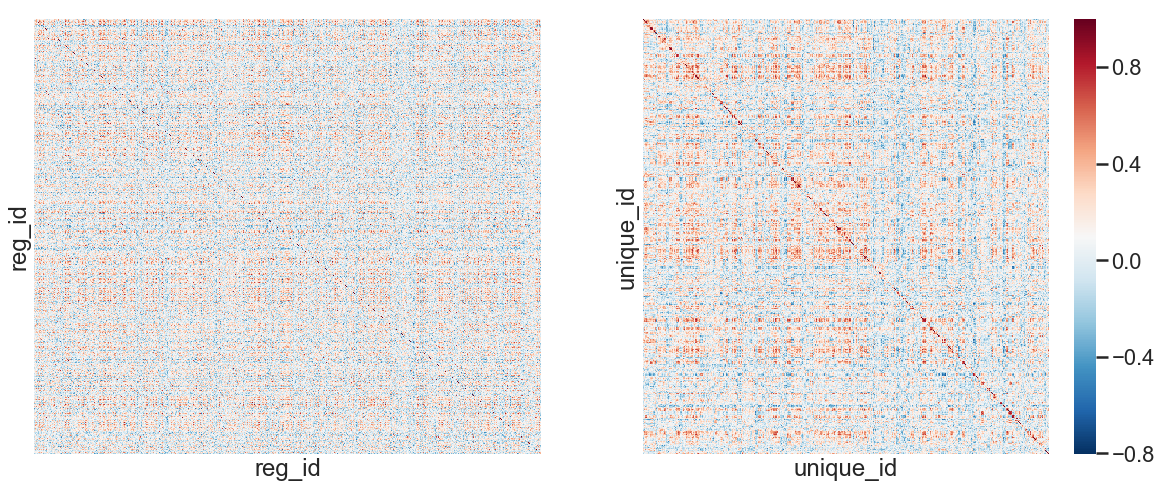

In [71]:
fig, axes = plt.subplots(1,2, figsize=(20,8))
sns.heatmap(reg_rsm, xticklabels=False, yticklabels=False, cmap = 'RdBu_r',  cbar=False, ax=axes[0])
sns.heatmap(rsm, xticklabels=False, yticklabels=False, cmap='RdBu_r', cbar=True, ax=axes[1])
plt.savefig('../img/subj_sim.png')

In [72]:
subj_within = np.zeros(np.shape(rsm))
reg_within = np.zeros(np.shape(rsm))

reg_cols = [x.split('_')[0] for x in reg_rsm.columns]
subj_cols = [x.split('_')[0] for x in rsm.columns]
reg_rows = [x.split('_')[0] for x in reg_rsm.index]
subj_rows = [x.split('_')[0] for x in rsm.index]
for s in np.unique(subj_rows):
    subj_within[np.where([x == s for x in subj_rows])[0][0]:(np.where([x == s for x in subj_rows])[0][-1] + 1),
                np.where([x == s for x in subj_cols])[0][0]:(np.where([x == s for x in subj_cols])[0][-1] + 1)] = 1
for r in np.unique(reg_rows):
    reg_within[np.where([x == r for x in reg_rows])[0][0]:(np.where([x == r for x in reg_rows])[0][-1] + 1),
                np.where([x == r for x in reg_cols])[0][0]:(np.where([x == r for x in reg_cols])[0][-1] + 1)] = 1

    

In [73]:
# within subj
rval = []
pval = []
label = []
ci_lo = []
ci_hi = []

subj_test = rsm.as_matrix()
x = subj_within[np.triu_indices(np.size(subj_cols),1)]
y = subj_test[np.triu_indices(np.size(subj_cols),1)]
x = x[[not i for i in np.isnan(y)]]
y = y[[not i for i in np.isnan(y)]]
[r,p] = sp.stats.pearsonr(x,y)
print([r,p*2])

r_z = np.arctanh(r)
se = 1/np.sqrt(np.size(x) - 3)
alpha = 0.05
z = sp.stats.norm.ppf(1-alpha/2)
lo, hi = np.tanh(r_z-z*se), np.tanh(r_z+z*se)

ci_hi.append(hi)
ci_lo.append(lo)
rval.append(r)
pval.append(p)
label.append('subj')

/Users/stiso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


[0.1281574060922031, 0.0]


In [74]:
# within reg
reg_test = reg_rsm.as_matrix()
x = reg_within[np.triu_indices(np.size(reg_cols),1)]
y = reg_test[np.triu_indices(np.size(reg_cols),1)]
x = x[[not i for i in np.isnan(y)]]
y = y[[not i for i in np.isnan(y)]]
[r,p] = sp.stats.pearsonr(x,y)
print([r,p*2]) #adding MC correction

r_z = np.arctanh(r)
se = 1/np.sqrt(np.size(x) - 3)
alpha = 0.05
z = sp.stats.norm.ppf(1-alpha/2)
lo, hi = np.tanh(r_z-z*se), np.tanh(r_z+z*se)

ci_lo.append(lo)
ci_hi.append(hi)
rval.append(r)
pval.append(p)
label.append('reg')

/Users/stiso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


[0.0022113429434806567, 0.0012217441833680333]


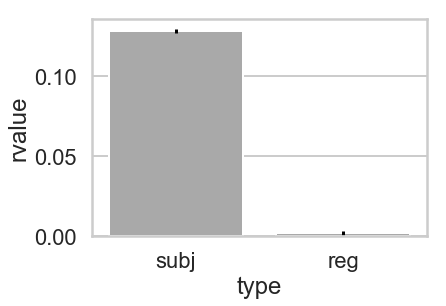

In [75]:
group_sim = pd.DataFrame({'type':label,'rvalue':(rval),'pvalue':pval, 
                          'ci':((np.array(ci_hi) - np.array(ci_lo))/2)})
sns.barplot(data=group_sim,x='type',y='rvalue',yerr=group_sim['ci'], color='darkgrey')
plt.savefig(f"../img/subj_reg_sim.pdf")

In [76]:
np.size(x)

2401318

## Effects on Node Measures

relationship between the number of spikes seen in that node, and the beta value

/Users/stiso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


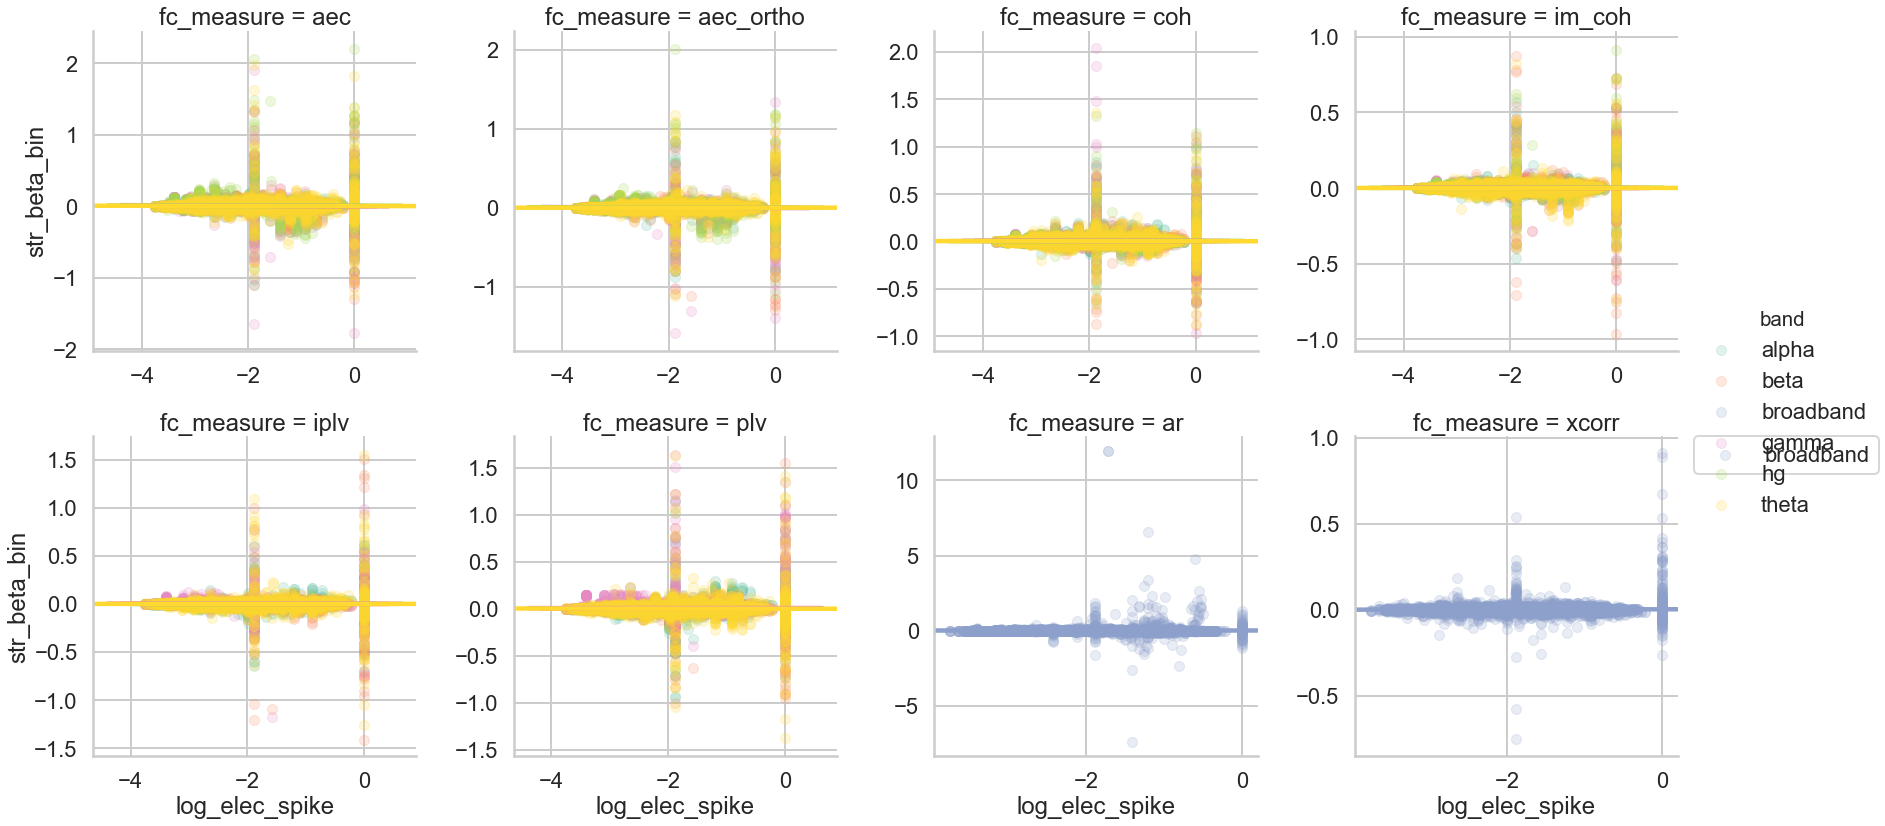

In [77]:
# add log transform
log_spike = np.zeros(np.shape(node_data['elec_spike']))
log_spike[[node_data['elec_spike'] != 0]] = np.log10(node_data['elec_spike'][node_data['elec_spike'] != 0])
node_data['log_elec_spike'] = log_spike

#color pallette
colors = ['#5b6c88', '#f0eee2']
custom_palette = sns.set_palette('Set2')

#plt.figure(figsize=(40,20))
sns.lmplot(data=node_data, x='log_elec_spike', y='str_beta_bin', hue='band', col="fc_measure", 
           col_wrap=4, height=6, sharex=False, sharey=False, scatter_kws={'s':100, 'alpha':.2})

plt.legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
#for ax in g.axes:
#    ax.set_ylim(-2,2)
    

# Sources of individual variability
## Check for differences based on coverage

D    63
M    35
G    13
Name: contacts, dtype: int64

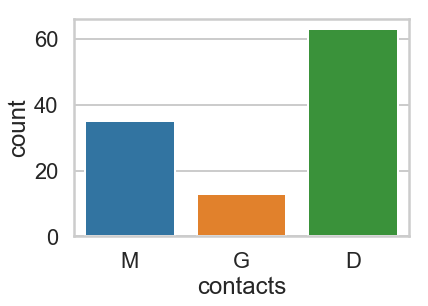

In [23]:
# check for strip grid difference
elec_type = node_data.groupby('subj').type.unique().reset_index()
def label_row(row):
    if ('G' in row['type']) & ('D' in row['type']):
        return 'M'
    elif all(('G' == row['type']) | ('S' == row['type'])):
        return 'G'
    elif all('D' == row['type']):
        return 'D'
    else:
        return np.nan
elec_type['contacts'] = elec_type.apply(lambda x: label_row(x), axis=1)
sns.countplot(elec_type.contacts)
elec_type.contacts.value_counts()

In [24]:
# merge
#net_data.drop('contacts_x', axis=1, inplace=True)
net_data = pd.merge(net_data, elec_type, on = 'subj')

In [25]:
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4260 entries, 0 to 4259
Data columns (total 43 columns):
band_measure              4260 non-null object
n_tp                      4260 non-null int64
str_beta_bin              4164 non-null float64
str_beta_num              4184 non-null float64
str_beta_spr              4170 non-null float64
ti_beta_bin               4172 non-null float64
ti_beta_num               4188 non-null float64
ti_beta_spr               4177 non-null float64
str_soz_beta_bin          2989 non-null float64
str_soz_beta_num          2993 non-null float64
str_soz_beta_spr          3004 non-null float64
str_not_soz_beta_num      2993 non-null float64
str_spike_beta_num        2932 non-null float64
str_not_soz_beta_spr      2994 non-null float64
str_not_soz_beta_bin      2978 non-null float64
str_spike_beta_bin        2930 non-null float64
str_spike_beta_spr        2942 non-null float64
str_not_spike_beta_bin    2918 non-null float64
Measure                   4260 n

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


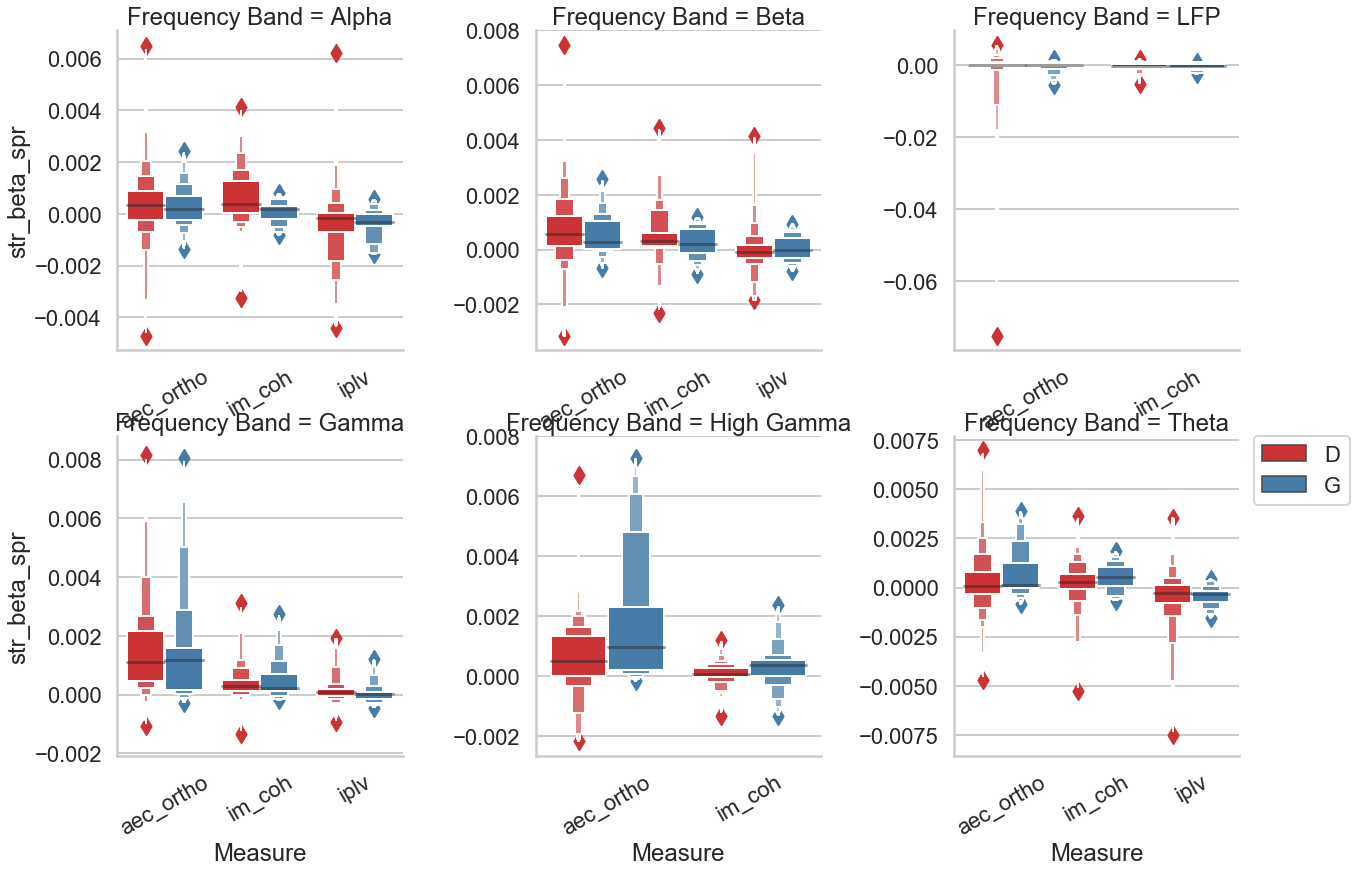

In [26]:
yvar = 'spr'
g = sns.FacetGrid(data=net_data[(net_data['Measure'] != 'aec') & (net_data['Measure'] != 'coh') & (net_data['Measure'] != 'plv')], col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=6, )
g.map(sns.boxenplot, 'Measure', 'str_beta_' + yvar, 'contacts', palette = 'Set1', 
      hue_order=['D','G'])
for a in g.axes:
    a.set_xticklabels(g.axes[0].xaxis.get_majorticklabels(),rotation=30)

g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
g.savefig(f"../img/contacts_{yvar}.pdf")

In [27]:
net_data = net_data.assign(type_diff_num = net_data['str_grid_beta_num'] - net_data['str_depth_beta_num'], 
                           type_diff_bin = net_data['str_grid_beta_bin'] - net_data['str_depth_beta_bin'],
                           type_diff_spr = net_data['str_grid_beta_spr'] - net_data['str_depth_beta_spr'])

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


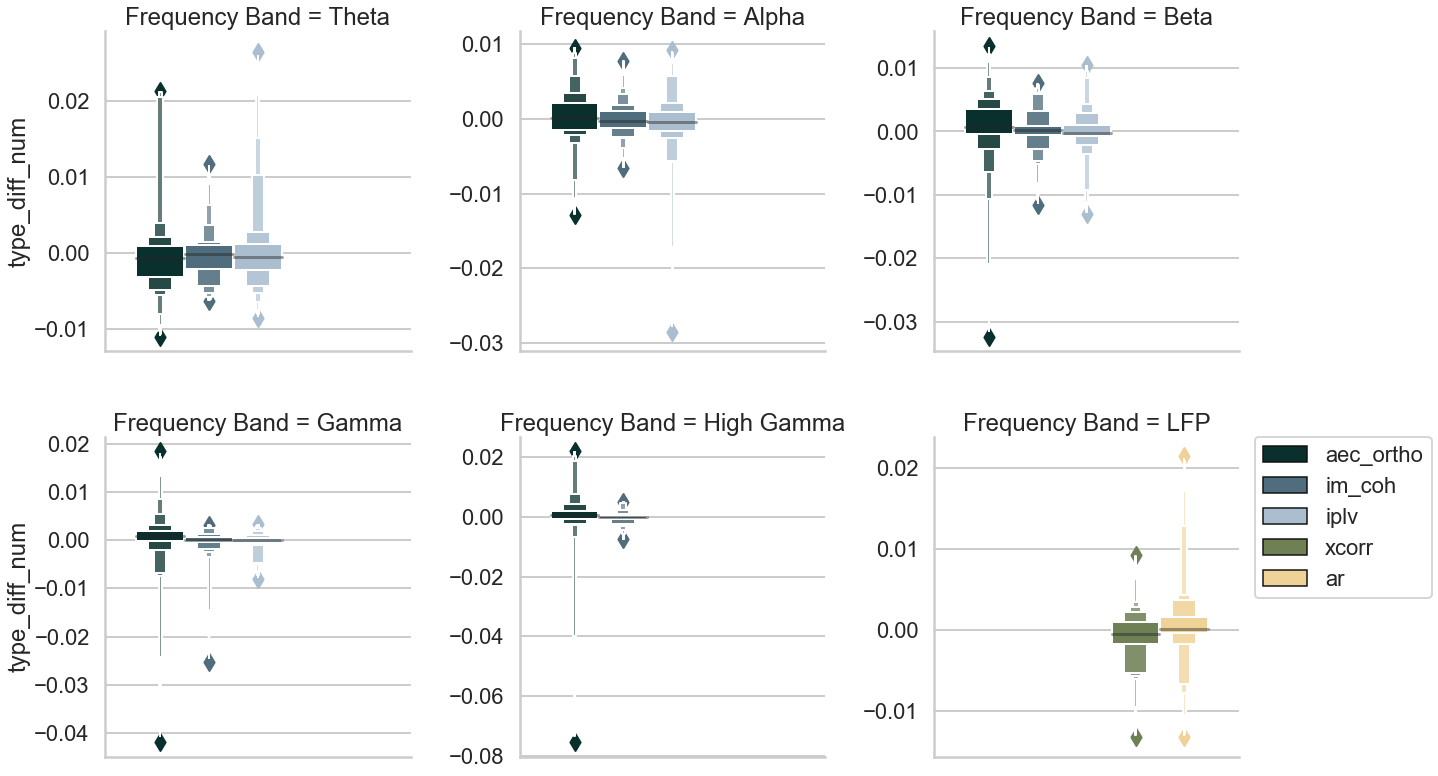

In [28]:
yvar = 'num'

colors = ['#023732', '#476f84', '#a4bed5', '#72874e', '#fed789']
h_order = ['aec_ortho', 'im_coh', 'iplv', 'xcorr', 'ar']

g=sns.FacetGrid(data=net_data, col="Frequency Band", col_wrap=3, col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'],
                sharex=False, sharey=False, height=6)
g.map(sns.boxenplot, "Frequency Band", "type_diff_" + yvar, "Measure",
             hue_order = h_order, palette=sns.color_palette(colors))
g.axes[5].legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)
for a in g.axes:
    a.axes.xaxis.set_visible(False)
g.savefig(f"../img/contacts_diff_{yvar}.pdf")

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


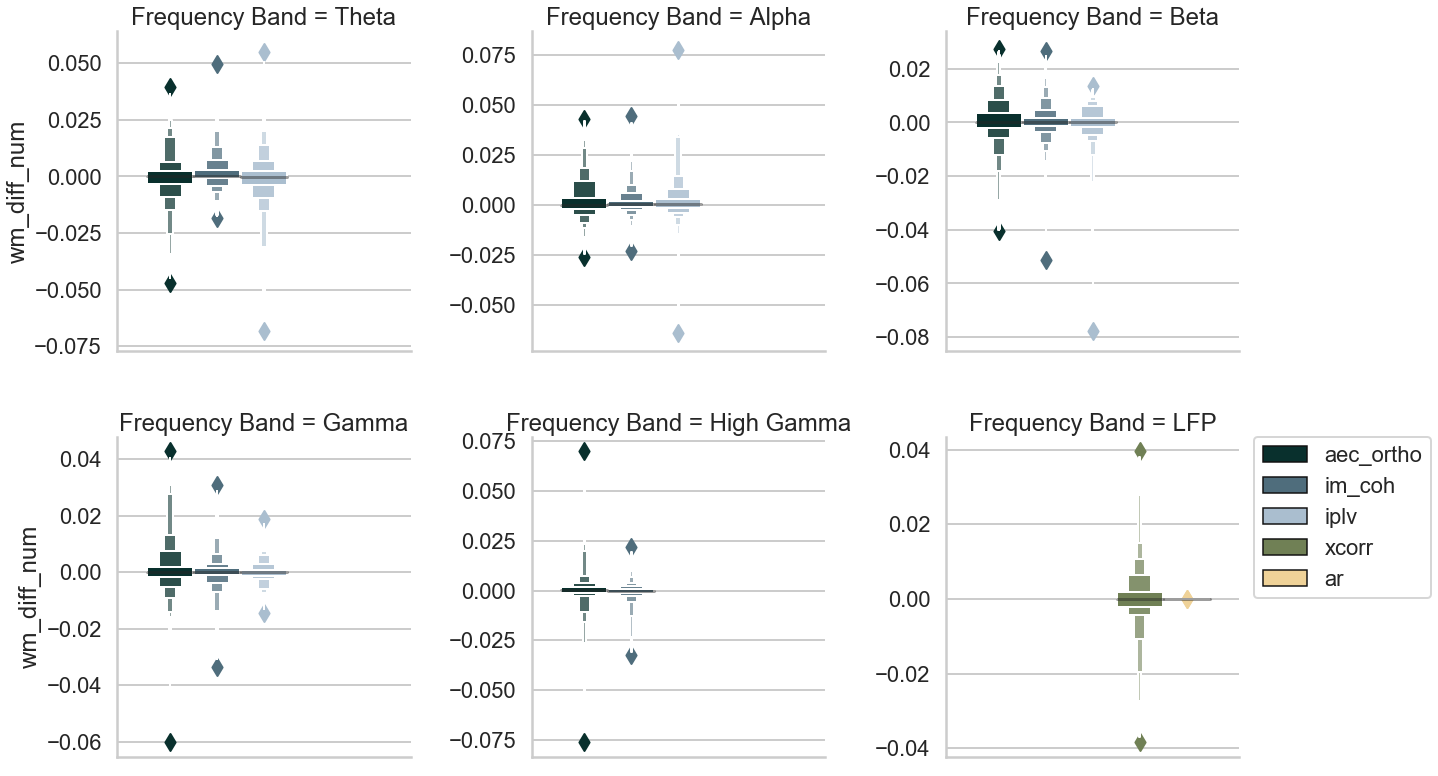

In [29]:
net_data = net_data.assign(wm_diff_num = net_data['str_gm_beta_num'] - net_data['str_wm_beta_num'], 
                           wm_diff_bin = net_data['str_gm_beta_bin'] - net_data['str_wm_beta_bin'],
                           wm_diff_spr = net_data['str_gm_beta_spr'] - net_data['str_wm_beta_spr'])

yvar = 'num'

colors = ['#023732', '#476f84', '#a4bed5', '#72874e', '#fed789']
h_order = ['aec_ortho', 'im_coh', 'iplv', 'xcorr', 'ar']

g=sns.FacetGrid(data=net_data, col="Frequency Band", col_wrap=3, col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'],
                sharex=False, sharey=False, height=6)
g.map(sns.boxenplot, "Frequency Band", "wm_diff_" + yvar, "Measure",
             hue_order = h_order, palette=sns.color_palette(colors))
g.axes[5].legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)
for a in g.axes:
    a.axes.xaxis.set_visible(False)
g.savefig(f"../img/wm_{yvar}.pdf")

In [30]:
net_data.subj.nunique()

142

## Variance by system

In [31]:
# load system data
sys = pd.read_csv(f'{RAM_dir}group_analysis/win_{win}/contact_sys.csv', index_col=0)


In [32]:
# check number of contacts
# contacts that are really far away end up labelled as vis
sys['sys'].value_counts()

Vis            97140
Default         4647
Limbic          2391
SalVentAttn     1940
SomMot          1597
Cont            1416
DorsAttn        1320
Name: sys, dtype: int64

In [33]:
sys.groupby(['subj','sys']).min_d.mean().head(25)

subj    sys        
R1001P  Cont            13.462925
        Default         16.000491
        DorsAttn        12.306150
        Limbic          20.120398
        SalVentAttn     15.065420
        SomMot          13.164589
        Vis             14.353137
R1002P  Cont            14.499693
        Default         20.114818
        DorsAttn        16.196721
        Limbic          19.731470
        SalVentAttn     19.326486
        SomMot          13.525720
        Vis             16.885360
R1003P  Vis                   NaN
R1004D  Cont           120.370063
        Default        153.841812
        SalVentAttn    128.240812
R1006P  Vis                   NaN
R1008J  Default         15.089609
        DorsAttn        16.060019
        Limbic          16.926507
        SalVentAttn     16.998840
        Vis             15.265479
R1009W  Vis                   NaN
Name: min_d, dtype: float64

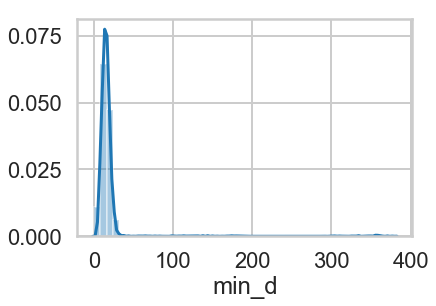

In [34]:
# how well are the MNI coordinates doing? Are centroids usually close?
sns.distplot(sys['min_d'].dropna())

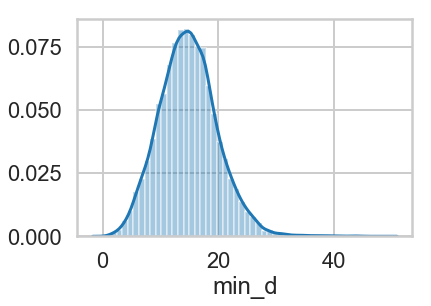

In [35]:
# get reid of contacts that clearly had poor match - greater than 2 std
sys.loc[sys['min_d'] > sys['min_d'].mean() + sys['min_d'].std(),['sys', 'parc', 'min_d', 'region']] = np.nan
sns.distplot(sys['min_d'].dropna())

In [36]:
# merge
node_data = pd.merge(node_data, sys, on=['subj', 'elec', 'region', 'x' ,'y', 'z', 'race', 
                                         'hand', 'gender', 'type', 'age'])
node_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2345010 entries, 0 to 2345009
Data columns (total 29 columns):
elec            object
band_measure    object
n_tp            int64
elec_spike      float64
elec_in_soz     int64
elec_in_ict     int64
ti_beta_bin     float64
ti_beta_num     float64
ti_beta_spr     float64
str_beta_spr    float64
str_beta_bin    float64
str_beta_num    float64
fc_measure      object
band            object
region          object
x               float64
y               float64
z               float64
type            object
wm              int64
subj            object
hand            object
age             float64
gender          object
race            float64
parc            object
sys             object
hem             object
min_d           float64
dtypes: float64(13), int64(4), object(12)
memory usage: 536.7+ MB


In [37]:
# get region -> system mapping to see if the MNI labels are any good
node_data.dropna(inplace=True, axis=0, subset=['min_d'])
reg_sys_map = node_data.groupby(['subj', 'elec'])[['region','sys']].head()
reg_sys_map.to_csv(f'{RAM_dir}group_analysis/win_{win}/reg_sys_map{detector}.csv')
reg_sys_map.head()


region      sys
0  inferiorparietal  Default
1  inferiorparietal  Default
2  inferiorparietal  Default
3  inferiorparietal  Default
4  inferiorparietal  Default

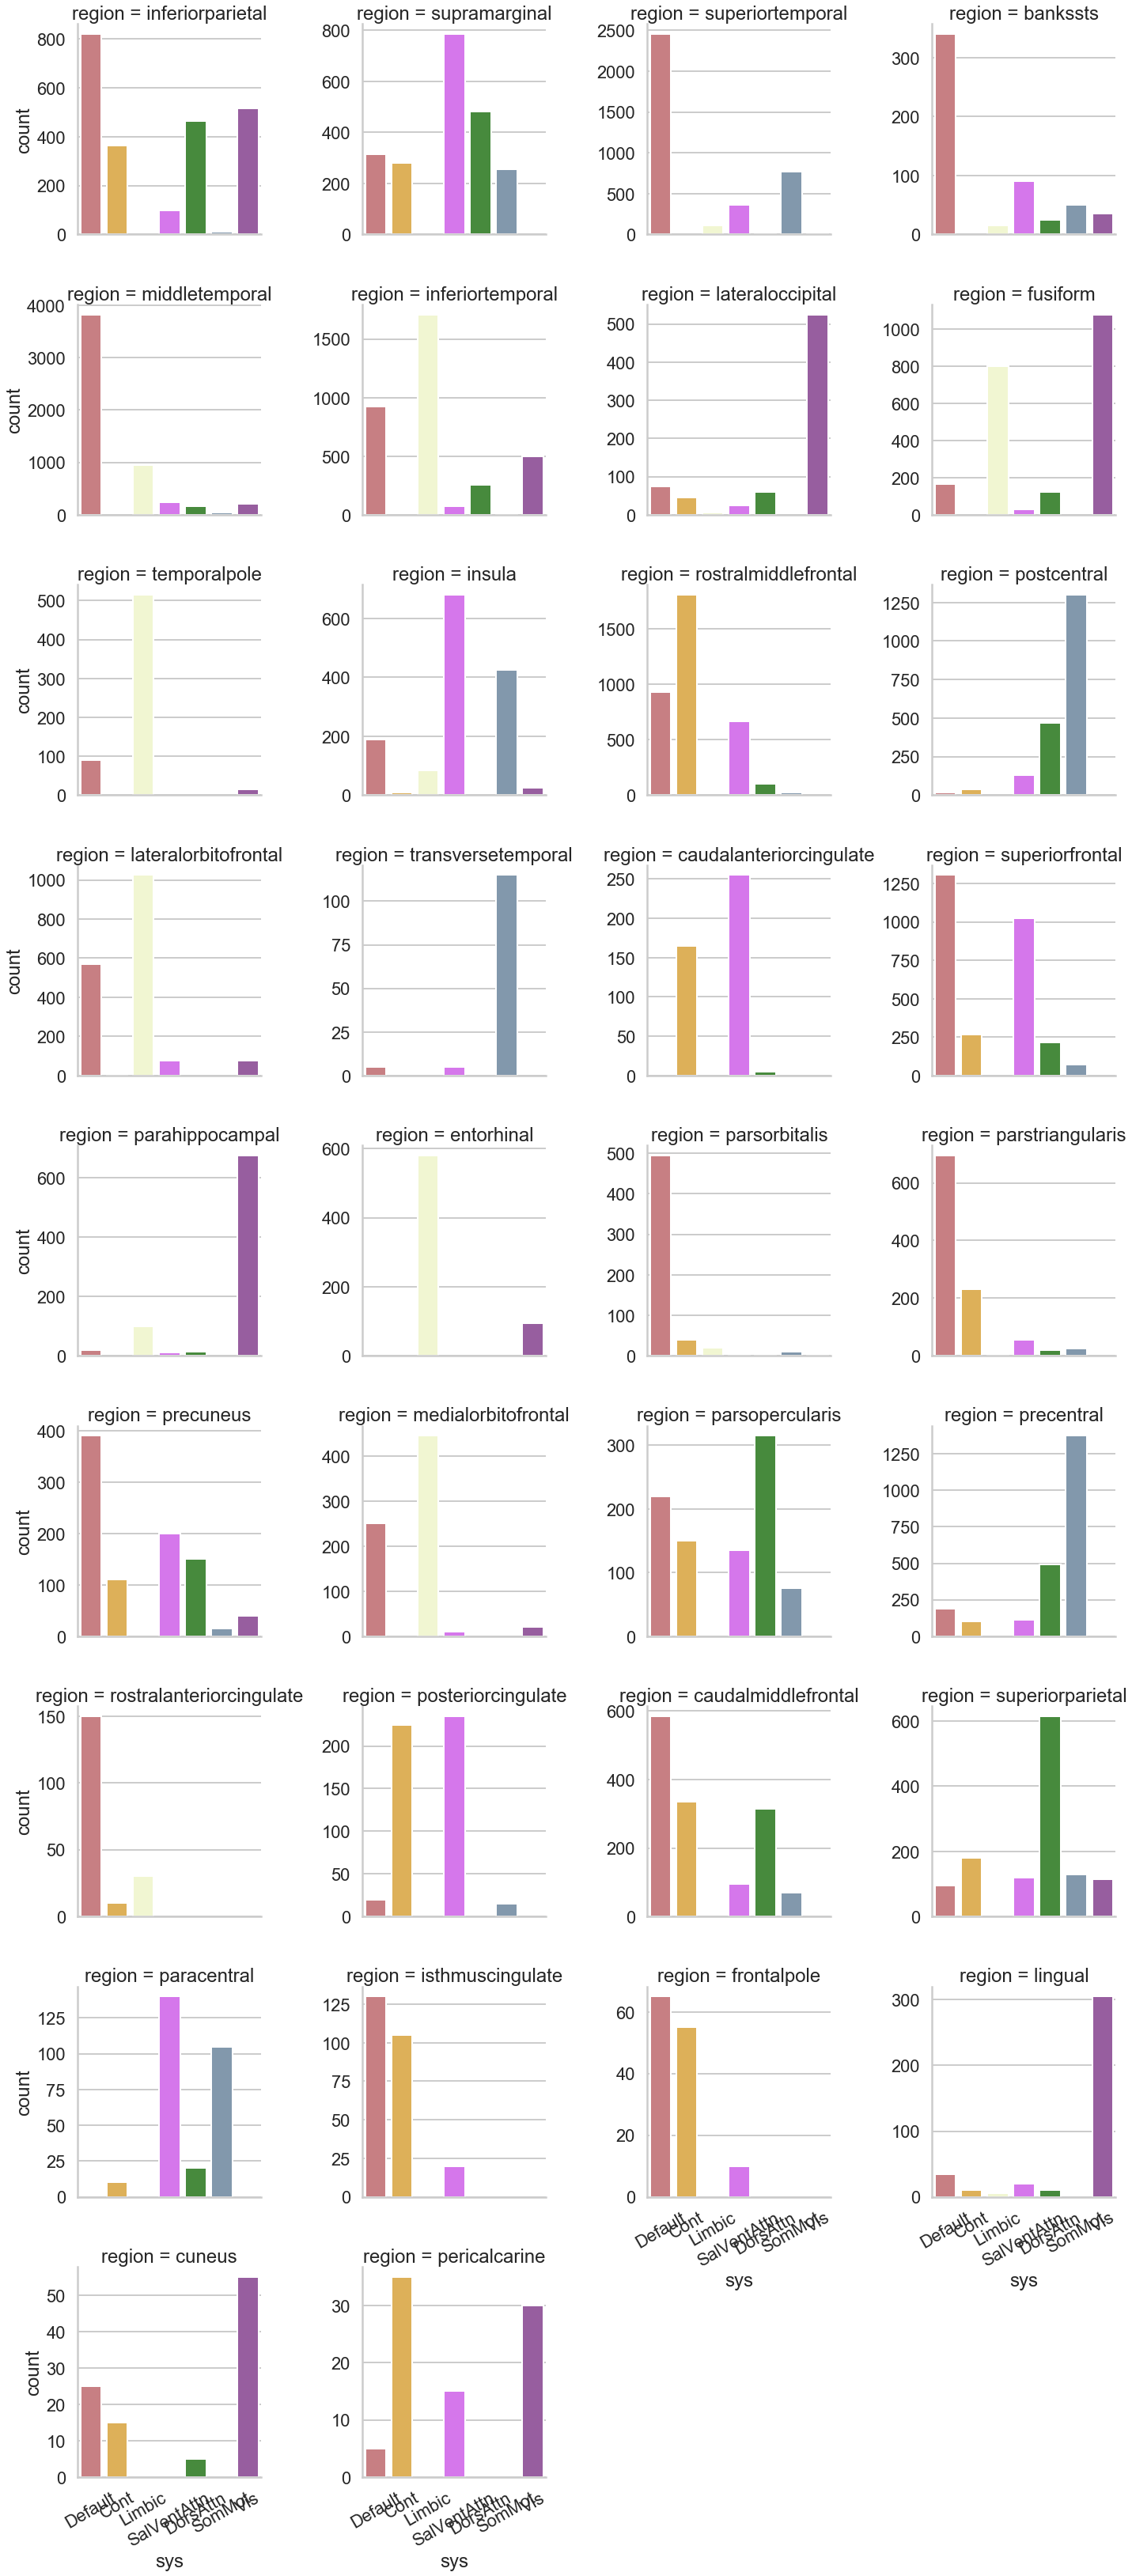

In [38]:
sys_colors = ['#d37379', '#f3b743', '#f5fccc', '#e164fe', '#3e9730', '#7b98b3', '#9f53aa']
sys_pal = sns.color_palette(sys_colors)
p = sns.catplot(data=reg_sys_map, x='sys', col='region', kind='count', col_wrap=4, sharey=False,
           order = ['Default', 'Cont', 'Limbic', 'SalVentAttn', 'DorsAttn', 'SomMot', 'Vis'],
           palette=sys_pal)
for a in p.axes:
    a.set_xticklabels(a.xaxis.get_majorticklabels(), rotation=30)
p.savefig(f'{RAM_dir}img/MNI_labels.png')

In [39]:
# z-score within subject node_data.drop(['scale_num', 'scale_bin'], axis=1, inplace=True) # comment this out if defining scaled vars for the first time
node_data.insert(5, 'scale_num', node_data.groupby(['subj', 'band_measure'])['str_beta_num'].transform(
    lambda x: sp.stats.zscore(x)))
node_data.insert(5, 'scale_bin', node_data.groupby(['subj', 'band_measure'])['str_beta_bin'].transform(
    lambda x: sp.stats.zscore(x)))
node_data.insert(5, 'scale_spr', node_data.groupby(['subj', 'band_measure'])['str_beta_spr'].transform(
    lambda x: sp.stats.zscore(x)))
# average over systems, so every subj has 1 pt per sys (if they had coverage there)
sys_avg = node_data.groupby(['subj', 'band', 'fc_measure', 'sys'])['scale_bin', 'scale_num', 'scale_spr'].median().reset_index()
sys_avg.head()
sys_avg.to_csv(f'{RAM_dir}group_analysis/win_{win}/sys_stats.csv')

/Users/stiso/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


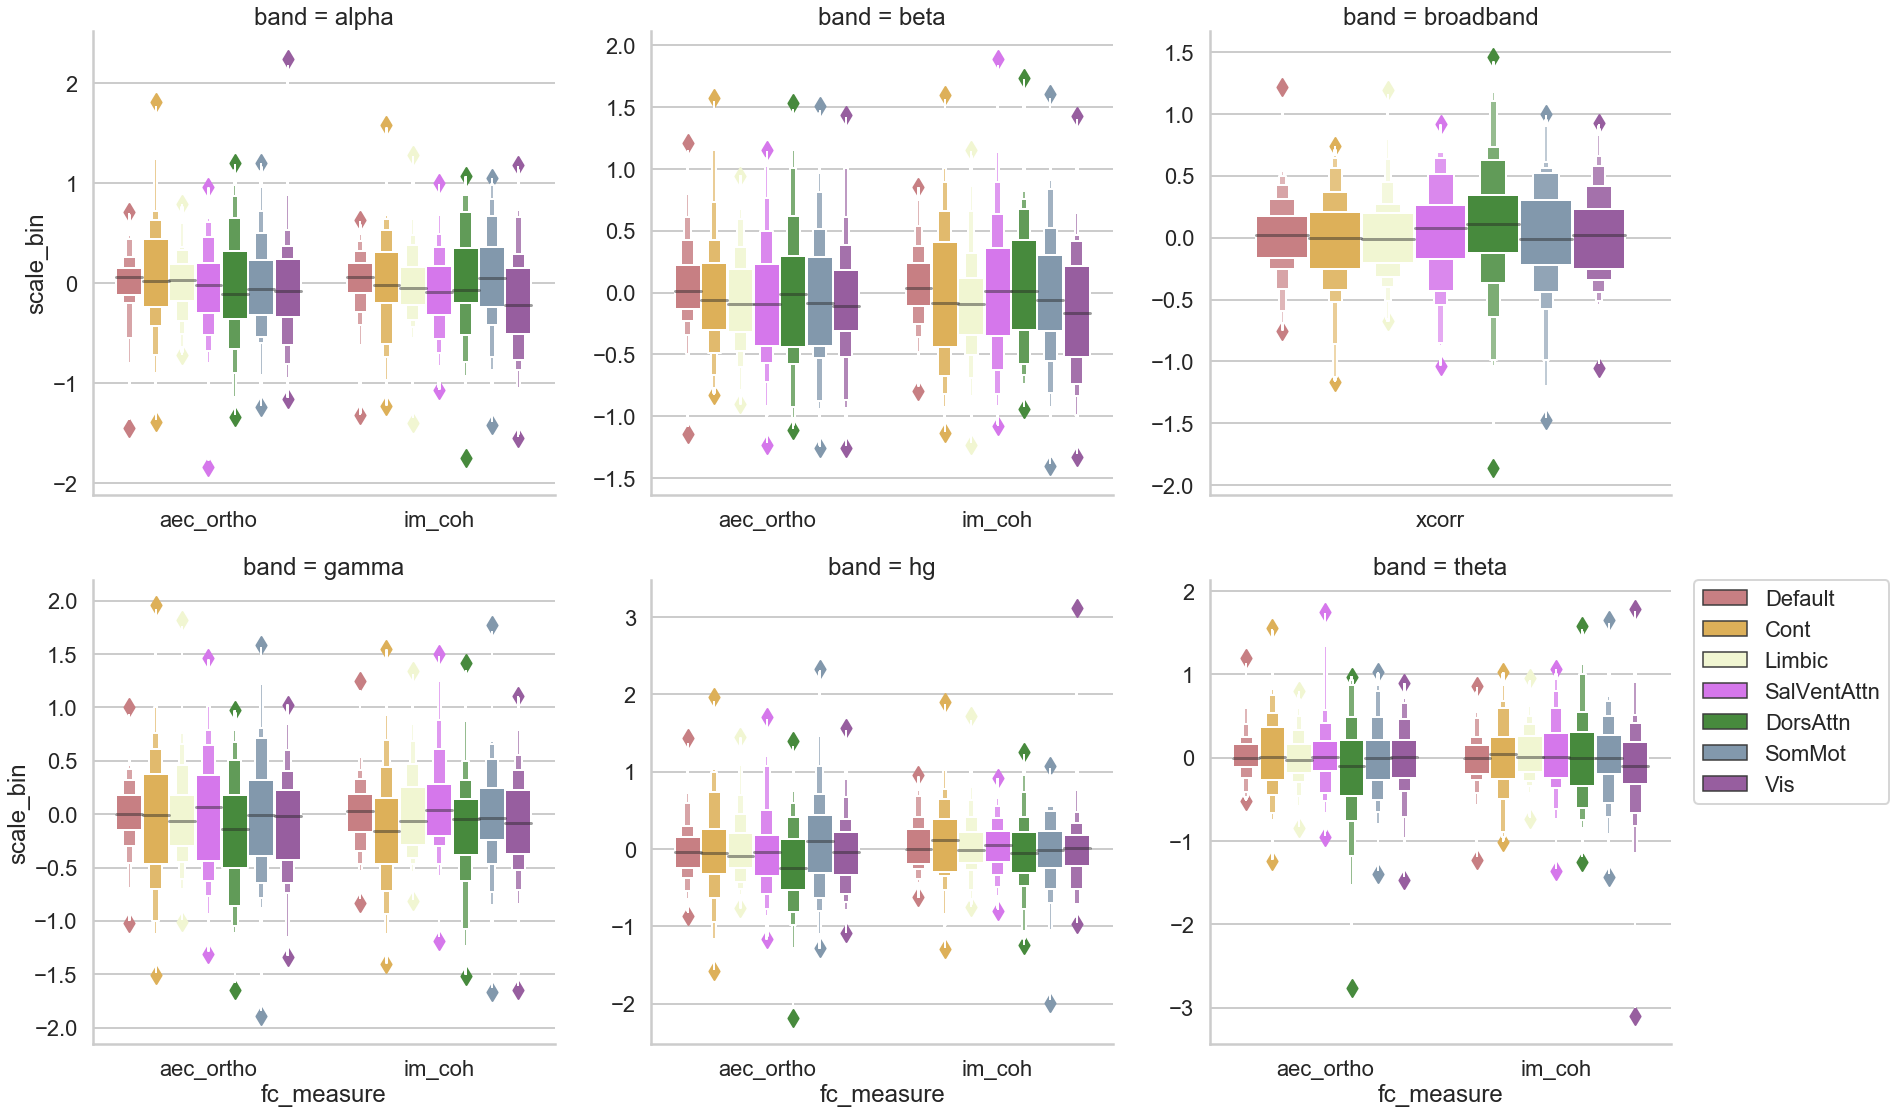

In [40]:
sys_avg = sys_avg[(sys_avg['fc_measure'] != 'aec') & (sys_avg['fc_measure'] != 'plv') & (sys_avg['fc_measure'] != 'coh')
                 & (sys_avg['fc_measure'] != 'iplv') & (sys_avg['fc_measure'] != 'ar')]
g = sns.FacetGrid(data=sys_avg, col='band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=8)
g.map(sns.boxenplot, 'fc_measure', 'scale_bin', 'sys', palette = sys_pal,
     hue_order = ['Default', 'Cont', 'Limbic', 'SalVentAttn', 'DorsAttn', 'SomMot', 'Vis'])
g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
#for ax in g.axes:
#    ax.set_ylim(-2,2)
    
g.savefig("../img/reg_sys.pdf")

## Clinical Data

In [41]:
clinical = pd.read_csv(f'{RAM_dir}RAM_Stiso.csv')

In [42]:
clinical.head()

Subject Lesional Institution   Age Sex       Race     Ethnicity  \
0        1      NaN        Penn  50.0   F      Black  Non-Hispanic   
1        2      NaN        Penn  51.0   F  Caucasian  Non-Hispanic   
2        3      NaN        Penn  41.0   F  Caucasian  Non-Hispanic   
3        4      NaN   Dartmouth  54.0   F  Caucasian  Non-Hispanic   
4        5      NaN        Penn  22.0   F  Caucasian  Non-Hispanic   

     Handedness  Education  SeizureAge Etiology  
0         Right       13.0        20.0  Unknown  
1         Right       16.0        34.0  Unknown  
2  Ambidextrous       13.0        37.0  Unknown  
3         Right       12.0         6.0    Other  
4           NaN        NaN         NaN      NaN

In [43]:
clinical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 11 columns):
Subject        408 non-null int64
Lesional       40 non-null object
Institution    408 non-null object
Age            388 non-null float64
Sex            392 non-null object
Race           372 non-null object
Ethnicity      368 non-null object
Handedness     372 non-null object
Education      296 non-null float64
SeizureAge     366 non-null float64
Etiology       339 non-null object
dtypes: float64(3), int64(1), object(7)
memory usage: 35.1+ KB


In [44]:
clinical.describe()

Subject         Age   Education  SeizureAge
count  408.000000  388.000000  296.000000  366.000000
mean   204.500000   36.579897   13.866554   18.198361
std    117.923704   11.538333    2.662342   12.973057
min      1.000000   17.000000    3.000000    0.000000
25%    102.750000   26.750000   12.000000    8.000000
50%    204.500000   36.000000   14.000000   16.000000
75%    306.250000   46.000000   16.000000   26.000000
max    408.000000   66.000000   24.000000   59.000000

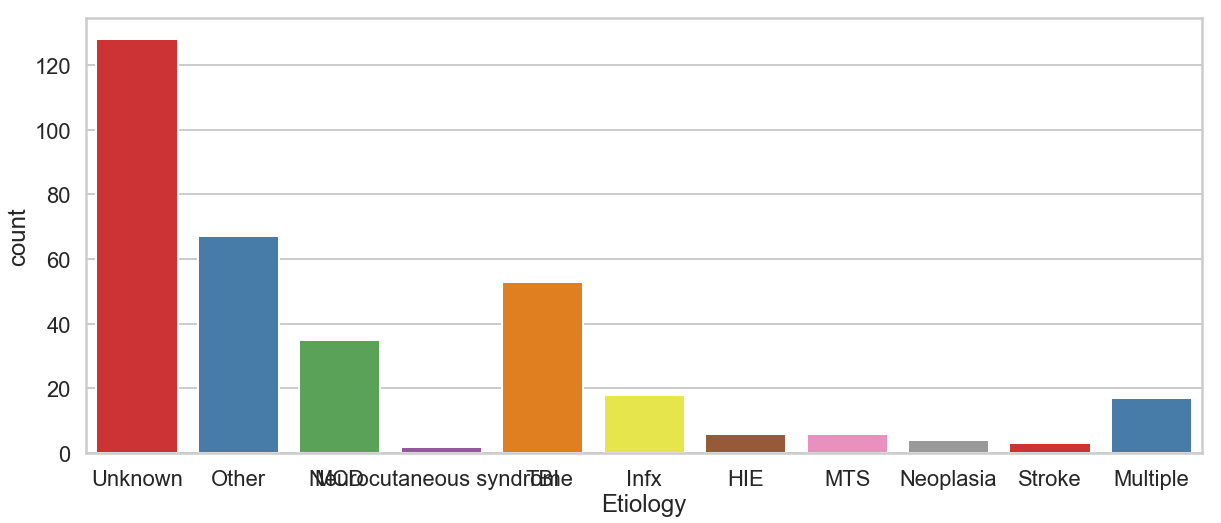

In [45]:
fig = plt.figure(figsize=(20,8))
sns.countplot(data=clinical, x='Etiology', palette = 'Set1')
plt.savefig("../img/etiology_ns.pdf")

In [46]:
clinical['Etiology'].value_counts()

Unknown                    128
Other                       67
TBI                         53
MCD                         35
Infx                        18
Multiple                    17
HIE                          6
MTS                          6
Neoplasia                    4
Stroke                       3
Neurocutaneous syndrome      2
Name: Etiology, dtype: int64

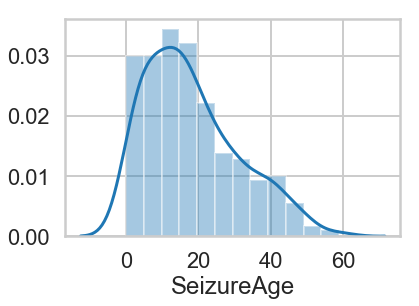

In [47]:
sns.distplot(clinical['SeizureAge'].dropna())

In [48]:
# get subject to the same naming convention
clinical['subj'] = clinical.apply(lambda x: 'R1' + '{0:0=3d}'.format(x['Subject']) + x['Institution'][0], axis=1)
clinical.drop(['Subject', 'Age', 'Sex', 'Race', 'Handedness'], axis=1, inplace=True)
clinical.head()

Lesional Institution     Ethnicity  Education  SeizureAge Etiology    subj
0      NaN        Penn  Non-Hispanic       13.0        20.0  Unknown  R1001P
1      NaN        Penn  Non-Hispanic       16.0        34.0  Unknown  R1002P
2      NaN        Penn  Non-Hispanic       13.0        37.0  Unknown  R1003P
3      NaN   Dartmouth  Non-Hispanic       12.0         6.0    Other  R1004D
4      NaN        Penn  Non-Hispanic        NaN         NaN      NaN  R1005P

In [49]:
# add 'nonlesional' category
clinical.loc[clinical['Lesional'].isna(),'Lesional'] = 'Nonlesional'
clinical.head()

Lesional Institution     Ethnicity  Education  SeizureAge Etiology  \
0  Nonlesional        Penn  Non-Hispanic       13.0        20.0  Unknown   
1  Nonlesional        Penn  Non-Hispanic       16.0        34.0  Unknown   
2  Nonlesional        Penn  Non-Hispanic       13.0        37.0  Unknown   
3  Nonlesional   Dartmouth  Non-Hispanic       12.0         6.0    Other   
4  Nonlesional        Penn  Non-Hispanic        NaN         NaN      NaN   

     subj  
0  R1001P  
1  R1002P  
2  R1003P  
3  R1004D  
4  R1005P

In [50]:
# merge with net data
subj_idx = [x in net_data.subj.unique() for x in clinical.subj]
net_data = pd.merge(net_data,clinical[subj_idx], on='subj', how='outer')
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4260 entries, 0 to 4259
Data columns (total 55 columns):
band_measure              4260 non-null object
n_tp                      4260 non-null int64
str_beta_bin              4164 non-null float64
str_beta_num              4184 non-null float64
str_beta_spr              4170 non-null float64
ti_beta_bin               4172 non-null float64
ti_beta_num               4188 non-null float64
ti_beta_spr               4177 non-null float64
str_soz_beta_bin          2989 non-null float64
str_soz_beta_num          2993 non-null float64
str_soz_beta_spr          3004 non-null float64
str_not_soz_beta_num      2993 non-null float64
str_spike_beta_num        2932 non-null float64
str_not_soz_beta_spr      2994 non-null float64
str_not_soz_beta_bin      2978 non-null float64
str_spike_beta_bin        2930 non-null float64
str_spike_beta_spr        2942 non-null float64
str_not_spike_beta_bin    2918 non-null float64
Measure                   4260 n

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


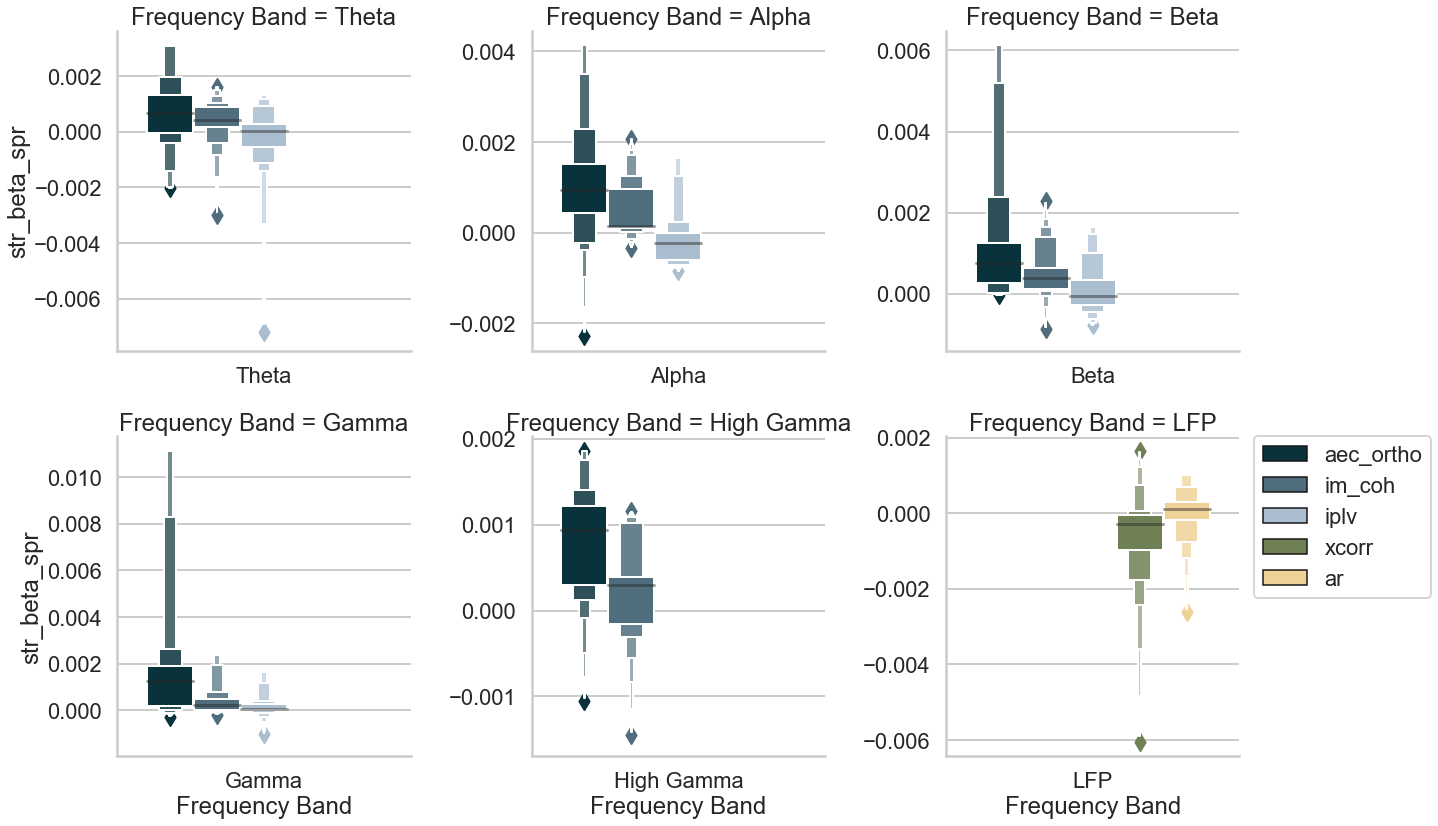

In [92]:
# sensitivity analysis
supp_flag = True # if true, includes orthogonal AEC
yvar = 'spr'
et = 'TBI'
if (not supp_flag):
    h_order = ['aec',  'coh', 'plv', 'xcorr', 'ar']
    supp_ext = ''
    # colors
    colors = ['#453947','#84476f', '#BB84C2', '#72874E', '#FED789']
    custom_palette = sns.set_palette(sns.color_palette(colors))
else:
    h_order = ['aec_ortho', 'im_coh', 'iplv', 'xcorr', 'ar']
    supp_ext = '_supp'
    # color pallette
    colors = ['#023743',  '#476f84', '#A4BED5', '#72874E', '#FED789']

    
g = sns.FacetGrid(data=net_data[net_data['Etiology'] == et], col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=6, 
                 col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'])
g.map(sns.boxenplot, 'Frequency Band', 'str_beta_' + yvar, 'Measure', palette = sns.color_palette(colors), 
      hue_order=h_order)

g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
g.savefig(f"../img/net_soz_{yvar}{detector}_{et}.eps")

In [51]:
net_data.subj.nunique()

142

In [93]:
# save
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/clinical{detector}.csv')

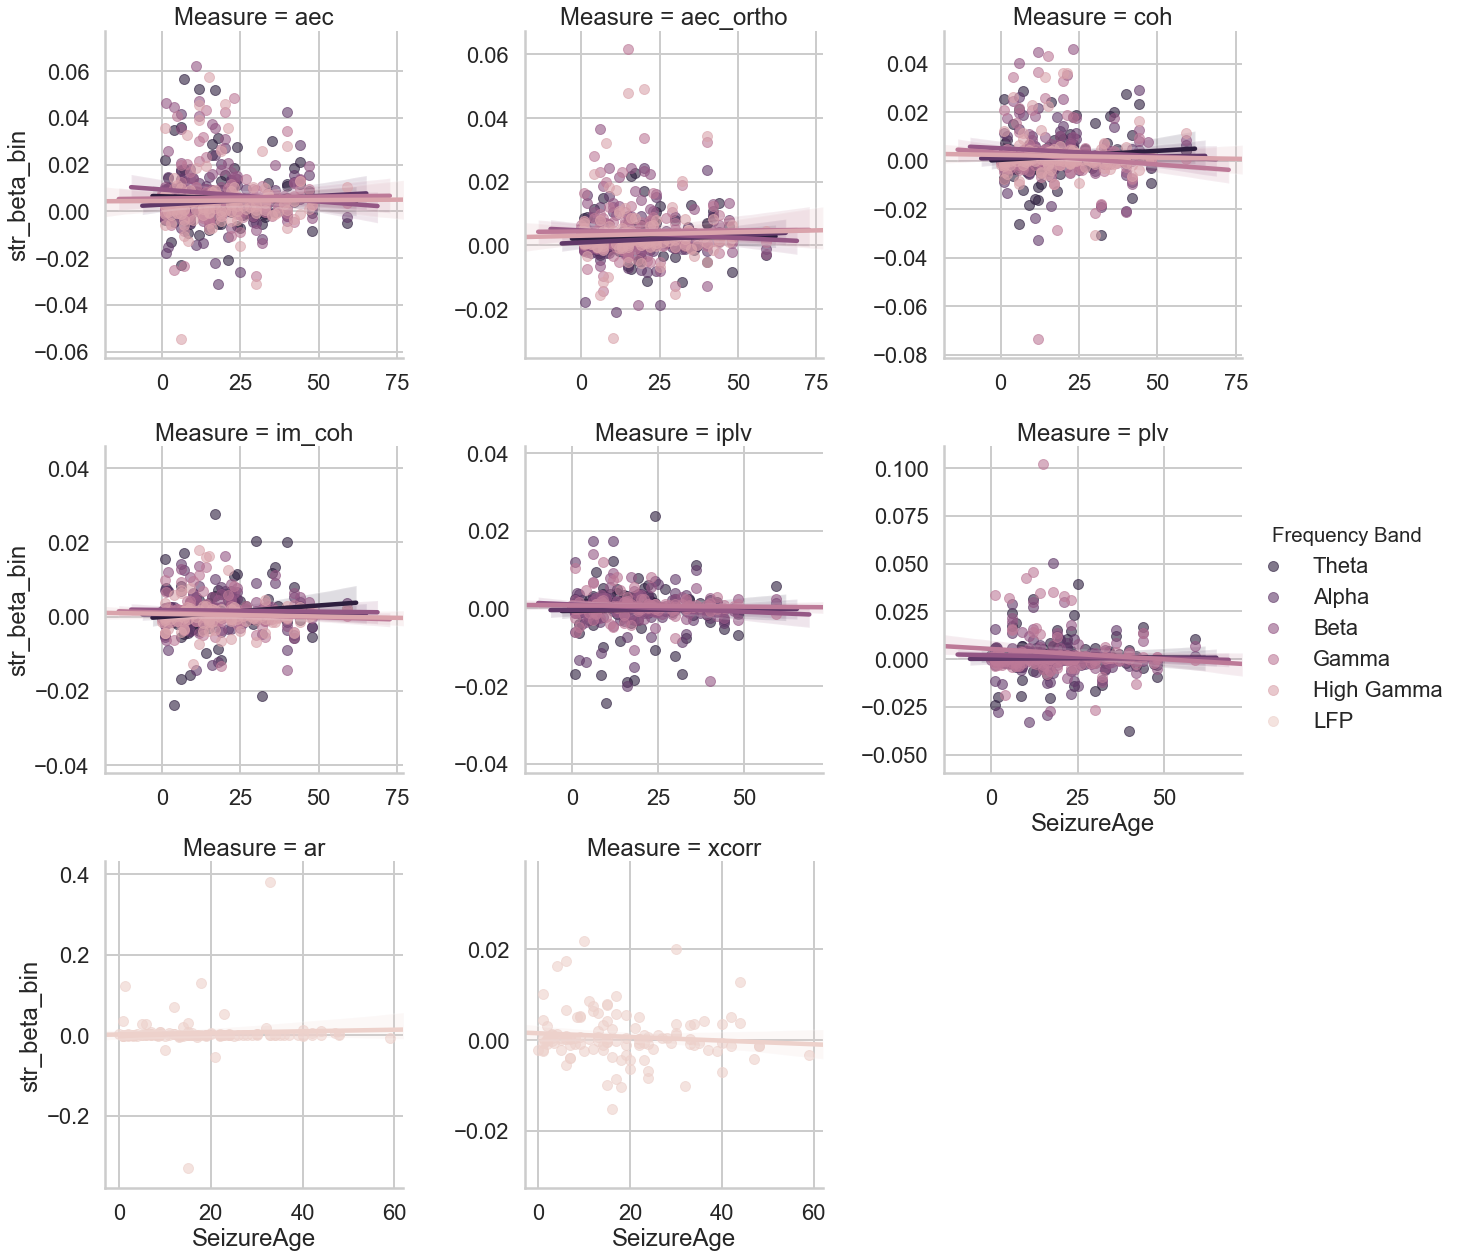

In [53]:
yvar='bin'
sns.lmplot(data=net_data, x='SeizureAge', y='str_beta_' + yvar, hue='Frequency Band', col="Measure", 
           col_wrap=3, height=6, sharex=False, sharey=False, 
           palette=sns.color_palette(sns.cubehelix_palette(6, reverse=True)), 
           scatter_kws={'s':100, 'alpha':.6}, 
           hue_order=['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'])
plt.savefig(f"../img/seizure_onset_{yvar}_{detector}.png")

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the boxenplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


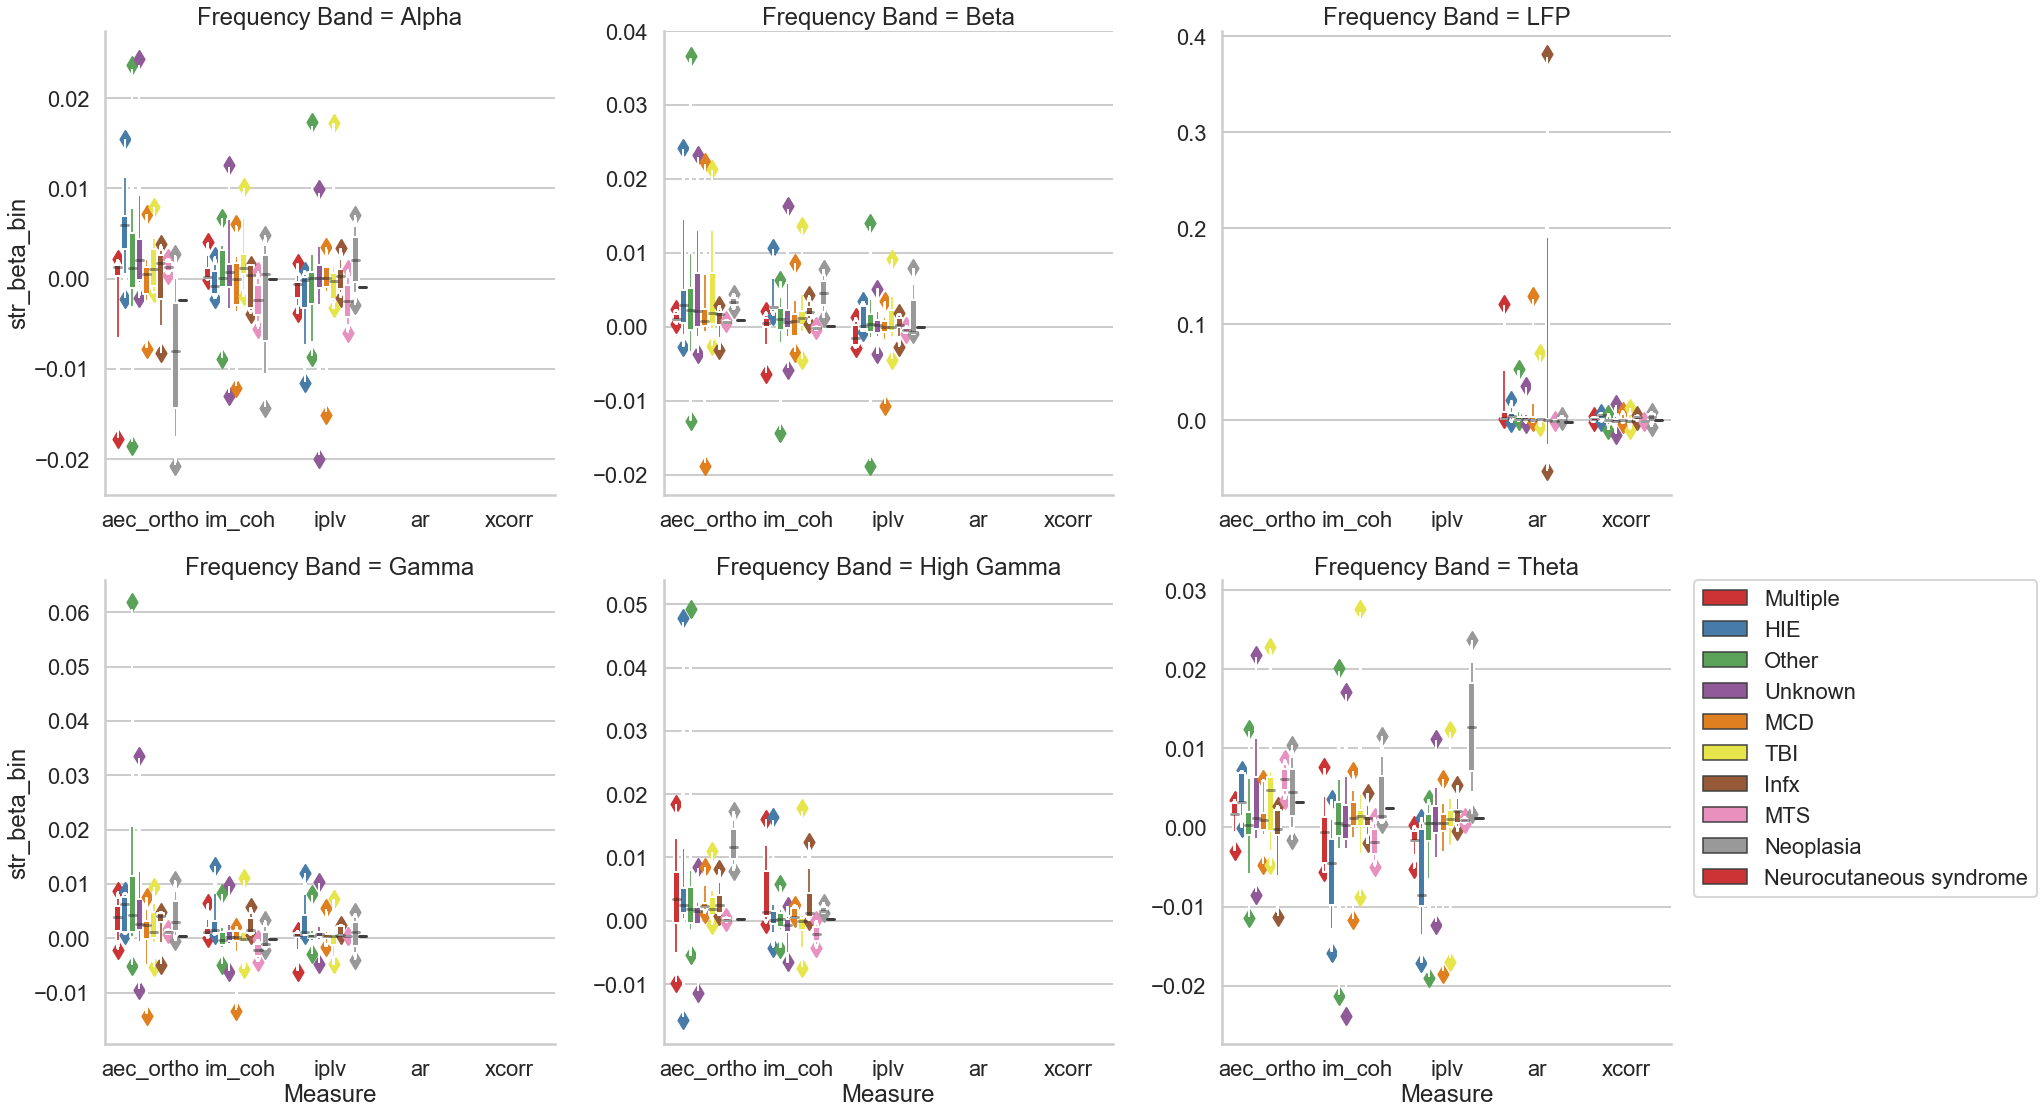

In [54]:
yvar = 'bin'
g = sns.FacetGrid(data=net_data[(net_data['Measure'] != 'aec') & (net_data['Measure'] != 'coh') & (net_data['Measure'] != 'plv')], 
                  col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=8)
g.map(sns.boxenplot, 'Measure', 'str_beta_' + yvar, 'Etiology', palette='Set1', order = ['aec_ortho', 'im_coh', 'iplv', 'ar', 'xcorr'])
g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
g.savefig(f'../img/etiology_{yvar}.pdf')

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the boxenplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


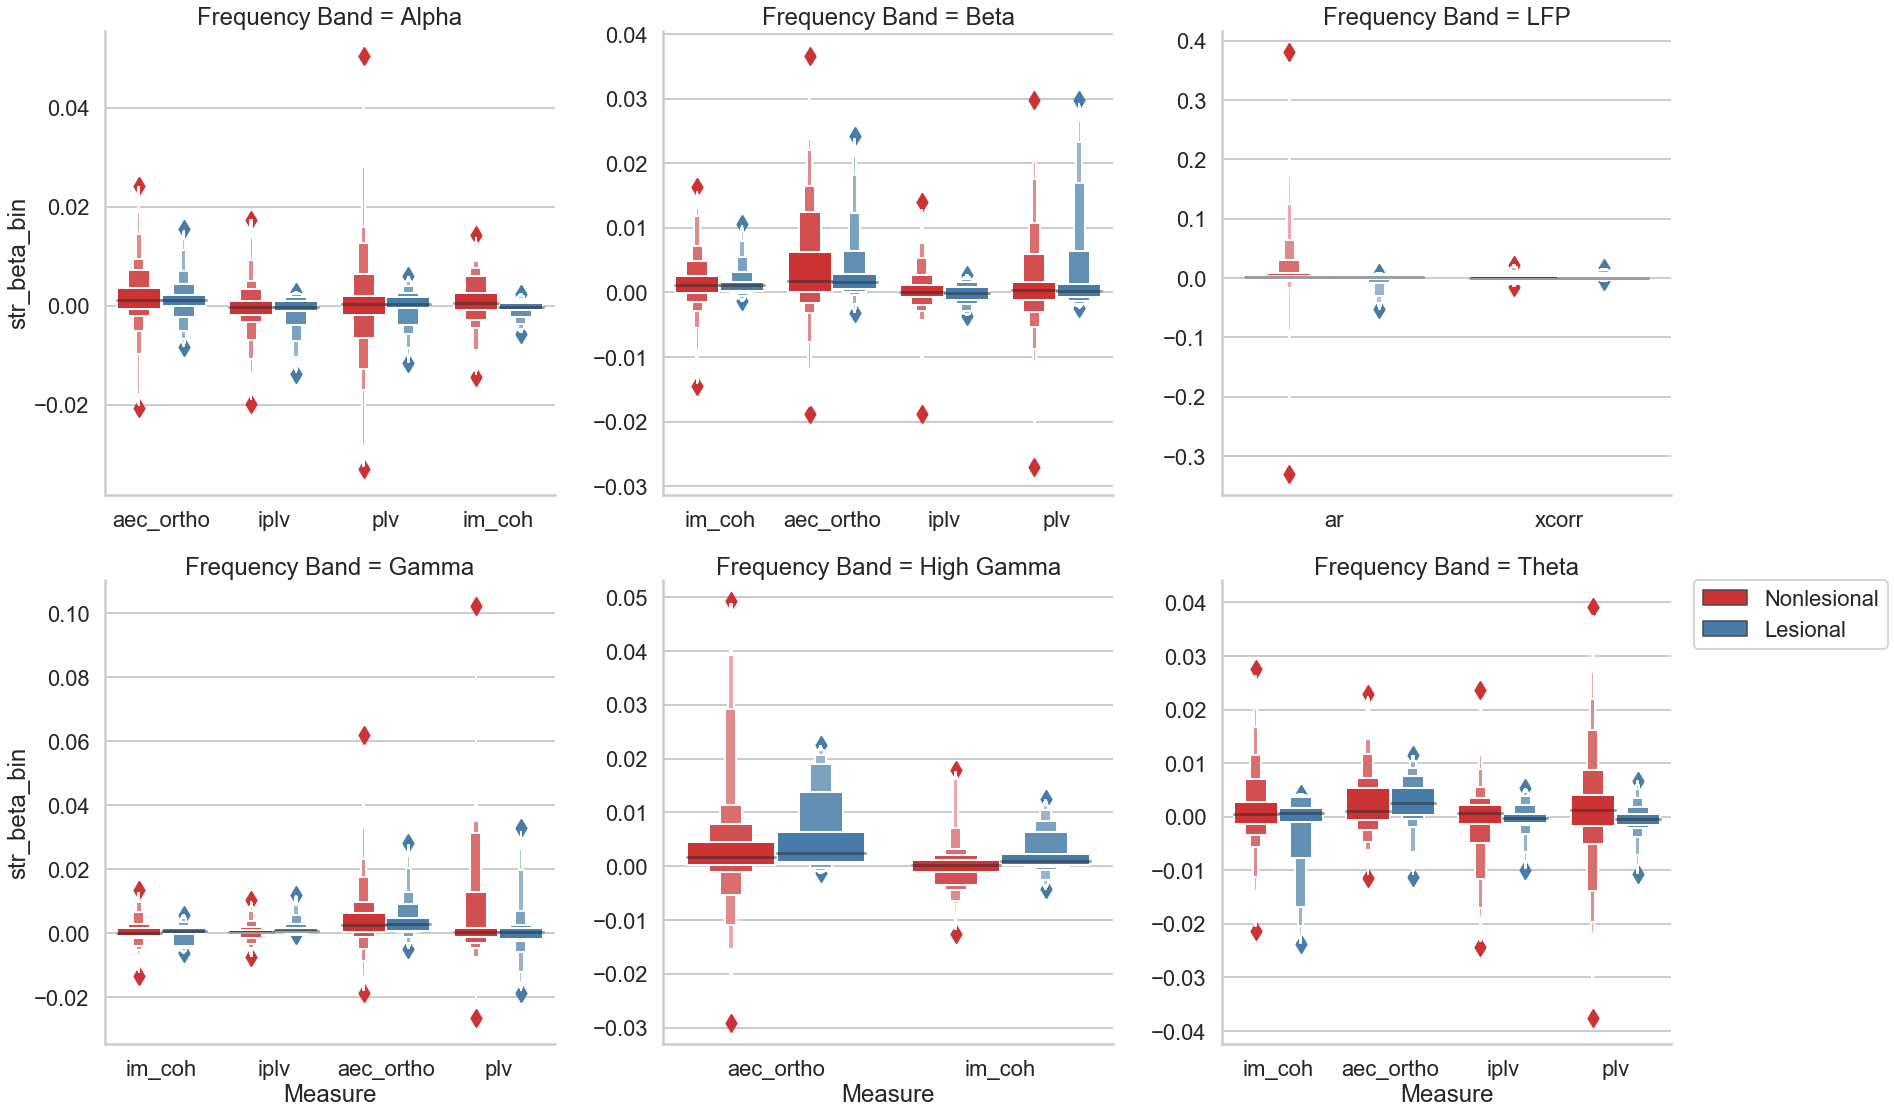

In [55]:
yvar = 'spr'
g = sns.FacetGrid(data=net_data[(net_data['Measure'] != 'aec') & (net_data['Measure'] != 'coh')], col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=8)
g.map(sns.boxenplot, 'Measure', 'str_beta_bin', 'Lesional', palette='Set1')
g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
g.savefig(f'../img/lesional_{yvar}.pdf')

### Categorize SOZ locus

In [56]:
# check labels of elecs in soz for which sys they are in
flag = 'spike' # spike or soz

epilepsy_type = pd.DataFrame(data={'subj':net_data.subj.unique(), 
                                   'locus':np.empty(net_data.subj.unique().shape),
                                  'hem':np.empty(net_data.subj.unique().shape)})
for index,row in epilepsy_type.iterrows():
    if flag == 'spike':
        curr = node_data[(node_data['subj'] == row.subj)]
        curr = curr[curr['elec_spike'] == curr['elec_spike'].max()]    
    else:
        curr = node_data[(node_data['subj'] == row.subj) & (node_data['elec_in_soz'] == 1)]
    if (np.shape(curr)[0] == 0):
        epilepsy_type.loc[index, 'locus'] = np.nan
        epilepsy_type.loc[index,'hem'] = np.nan
    else:
        epilepsy_type.loc[index,'locus'] = curr.sys.mode()[0]
        epilepsy_type.loc[index, 'hem']= curr.hem.mode()[0]
    
epilepsy_type.head()           

subj   locus  hem
0  R1235E     NaN  NaN
1  R1170J  SomMot   LH
2  R1291M     NaN  NaN
3  R1285C     NaN  NaN
4  R1284N  SomMot   LH

In [57]:
node_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300030 entries, 0 to 2345009
Data columns (total 32 columns):
elec            300030 non-null object
band_measure    300030 non-null object
n_tp            300030 non-null int64
elec_spike      300030 non-null float64
elec_in_soz     300030 non-null int64
scale_spr       248160 non-null float64
scale_bin       225990 non-null float64
scale_num       248160 non-null float64
elec_in_ict     300030 non-null int64
ti_beta_bin     295530 non-null float64
ti_beta_num     297180 non-null float64
ti_beta_spr     297180 non-null float64
str_beta_spr    297180 non-null float64
str_beta_bin    295531 non-null float64
str_beta_num    297180 non-null float64
fc_measure      300030 non-null object
band            300030 non-null object
region          274230 non-null object
x               300030 non-null float64
y               300030 non-null float64
z               300030 non-null float64
type            300030 non-null object
wm              3000

In [58]:
epilepsy_type.dropna().subj.nunique()

107

In [59]:
node_data.region.unique()

array(['inferiorparietal', 'supramarginal', 'superiortemporal',
       'bankssts', 'middletemporal', 'inferiortemporal',
       'lateraloccipital', 'fusiform', 'temporalpole', 'insula',
       'rostralmiddlefrontal', 'postcentral', 'lateralorbitofrontal', nan,
       'transversetemporal', 'caudalanteriorcingulate', 'superiorfrontal',
       'parahippocampal', 'entorhinal', 'parsorbitalis',
       'parstriangularis', 'precuneus', 'medialorbitofrontal',
       'parsopercularis', 'precentral', 'rostralanteriorcingulate',
       'posteriorcingulate', 'caudalmiddlefrontal', 'superiorparietal',
       'paracentral', 'isthmuscingulate', 'frontalpole', 'lingual',
       'cuneus', 'pericalcarine'], dtype=object)

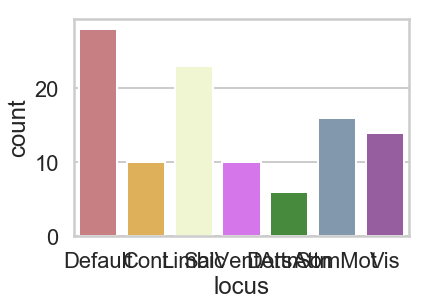

In [60]:
sns.countplot(data=epilepsy_type, x='locus', palette = sys_pal, 
              order = ['Default', 'Cont','Limbic', 'SalVentAttn','DorsAttn', 'SomMot','Vis'],
             hue_order = ['Default', 'Cont', 'Limbic', 'SalVentAttn', 'DorsAttn', 'SomMot', 'Vis'])

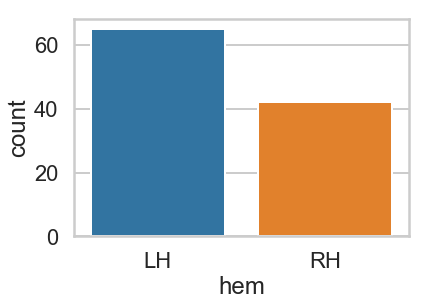

In [61]:
sns.countplot(data=epilepsy_type, x='hem')

In [62]:
# add locus back to big data frames
#net_data.drop(['locus', 'hem'],axis=1,inplace=True)
net_data = pd.merge(net_data, epilepsy_type, on='subj',how='outer')
#node_data = pd.merge(node_data, epilepsy_type, on='subj')
net_data.head()

band_measure  n_tp  str_beta_bin  str_beta_num  str_beta_spr  \
0        alpha_aec    76     -0.017848     -0.038376      0.001960   
1  alpha_aec_ortho    76     -0.017813           NaN      0.001179   
2        alpha_coh    76           NaN           NaN     -0.003299   
3     alpha_im_coh    76           NaN           NaN     -0.003252   
4       alpha_iplv    76      0.001666      0.004304      0.000726   

   ti_beta_bin  ti_beta_num  ti_beta_spr  str_soz_beta_bin  str_soz_beta_num  \
0          NaN          NaN    -0.028822               NaN               NaN   
1          NaN          NaN     0.015400               NaN               NaN   
2          NaN          NaN     0.046141               NaN               NaN   
3          NaN    -0.365368    -0.002437               NaN               NaN   
4          NaN          NaN     0.015346               NaN               NaN   

  ...   wm_diff_bin  wm_diff_spr     Lesional  Institution     Ethnicity  \
0 ...           NaN          NaN  Nonlesional        Emory  Non-Hispanic   
1 ...           NaN          NaN  Nonlesional        Emory  Non-Hispanic   
2 ...           NaN     0.008859  Nonlesional        Emory  Non-Hispanic   
3 ...           NaN          NaN  Nonlesional        Emory  Non-Hispanic   
4 ...     -0.000188    -0.001622  Nonlesional        Emory  Non-Hispanic   

   Education  SeizureAge  Etiology locus  hem  
0       12.0         1.3  Multiple   NaN  NaN  
1       12.0         1.3  Multiple   NaN  NaN  
2       12.0         1.3  Multiple   NaN  NaN  
3       12.0         1.3  Multiple   NaN  NaN  
4       12.0         1.3  Multiple   NaN  NaN  

[5 rows x 57 columns]

In [63]:
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4260 entries, 0 to 4259
Data columns (total 57 columns):
band_measure              4260 non-null object
n_tp                      4260 non-null int64
str_beta_bin              4164 non-null float64
str_beta_num              4184 non-null float64
str_beta_spr              4170 non-null float64
ti_beta_bin               4172 non-null float64
ti_beta_num               4188 non-null float64
ti_beta_spr               4177 non-null float64
str_soz_beta_bin          2989 non-null float64
str_soz_beta_num          2993 non-null float64
str_soz_beta_spr          3004 non-null float64
str_not_soz_beta_num      2993 non-null float64
str_spike_beta_num        2932 non-null float64
str_not_soz_beta_spr      2994 non-null float64
str_not_soz_beta_bin      2978 non-null float64
str_spike_beta_bin        2930 non-null float64
str_spike_beta_spr        2942 non-null float64
str_not_spike_beta_bin    2918 non-null float64
Measure                   4260 n

In [64]:
net_data.subj.nunique()

142

## Net plots with category by locus

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


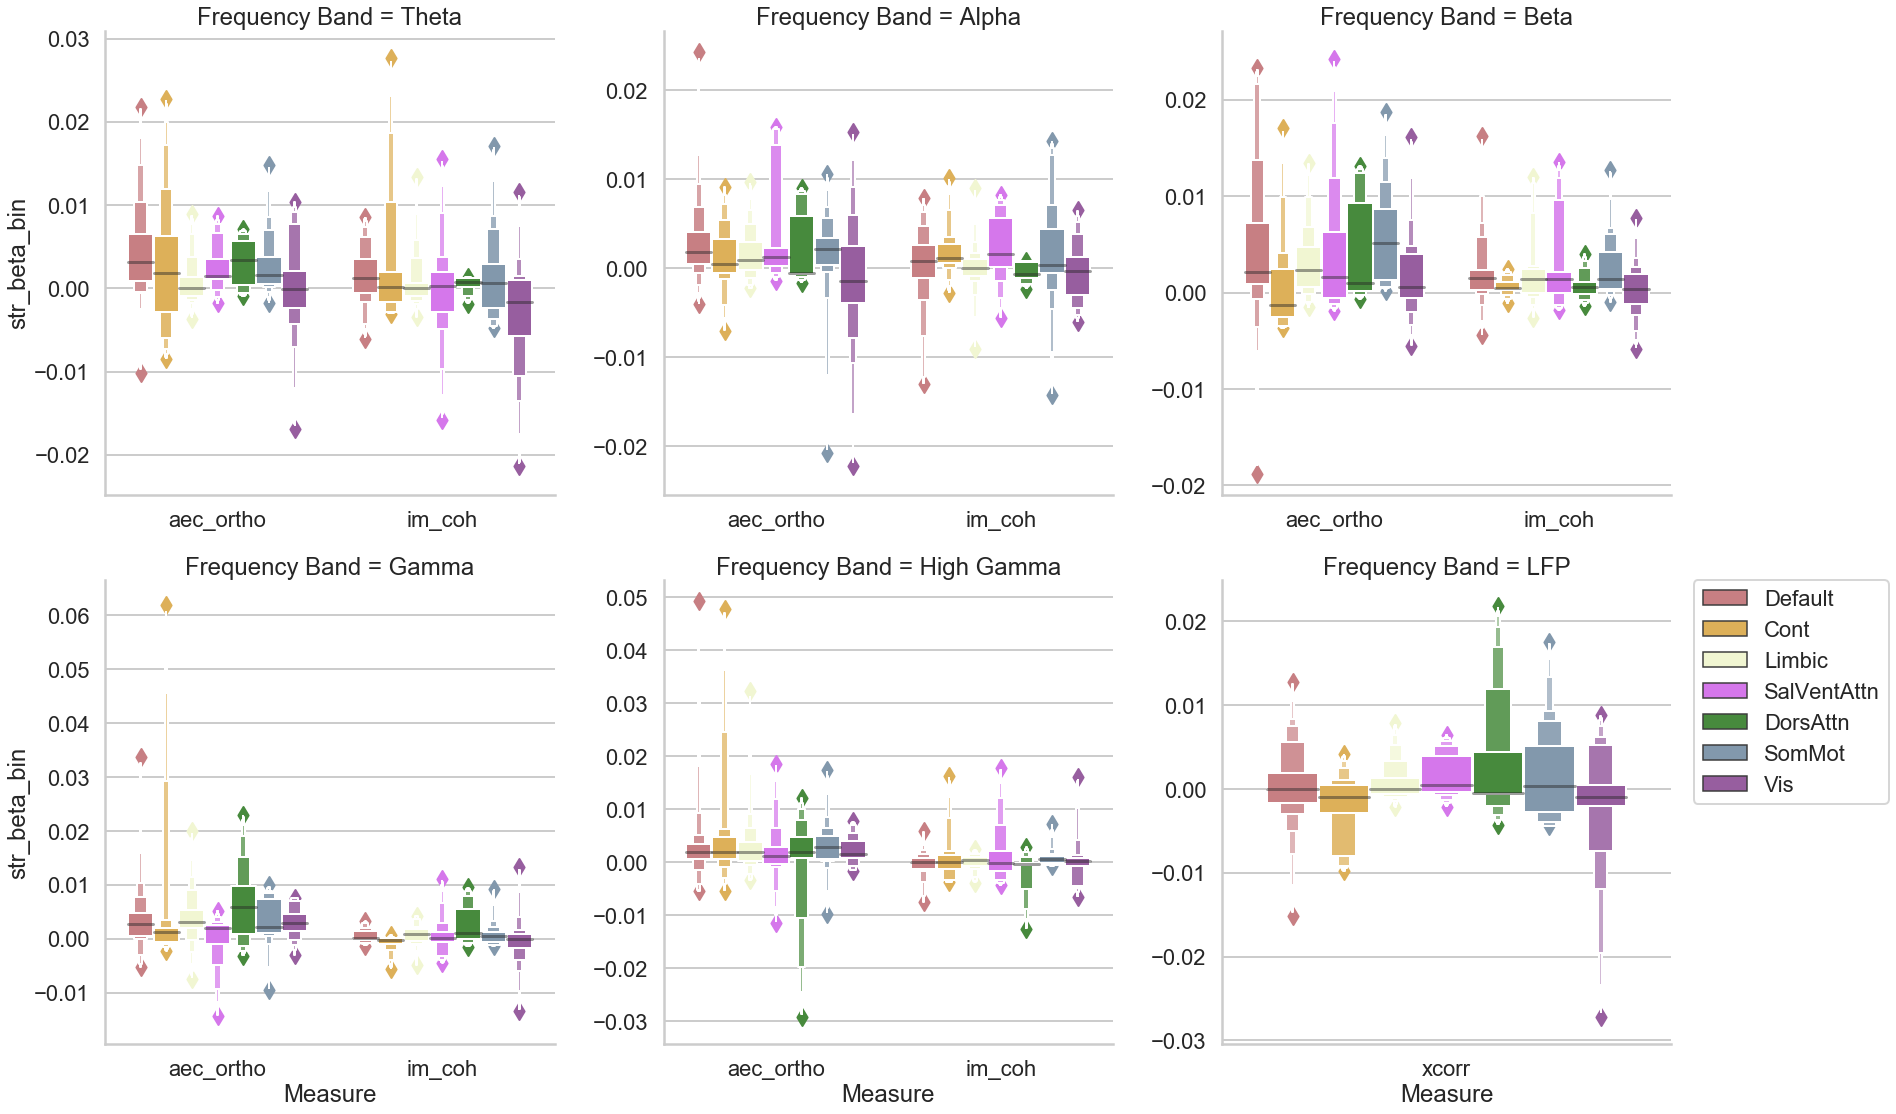

In [65]:
yvar = 'bin'
g = sns.FacetGrid(data=net_data[(net_data.Measure != 'aec') & (net_data.Measure != 'coh') & 
                                (net_data.Measure != 'plv') & (net_data.Measure != 'iplv') & (net_data.Measure != 'ar')], col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=8, col_order = ['Theta', 'Alpha', 'Beta', 'Gamma','High Gamma', 'LFP'])
g.map(sns.boxenplot, 'Measure', 'str_beta_' + yvar, 'locus', palette = sys_pal, 
      hue_order = ['Default', 'Cont', 'Limbic', 'SalVentAttn', 'DorsAttn', 'SomMot', 'Vis'])
g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
#for ax in g.axes:
#    ax.set_ylim(-5,5)
    
g.savefig(f'../img/soz_region_{yvar}{detector}.pdf')

In [66]:
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/sys_{flag}{detector}.csv')

## Behavior

In [67]:
task_data = pd.read_csv(f'{RAM_dir}group_analysis/task_performance.csv', index_col=0)
task_data.reset_index(inplace=True)
task_data.head(10)

subj        YC  TH       PAL  catFR        FR
0  R1001P  0.345526 NaN  0.041370    NaN  0.546573
1  R1002P       NaN NaN  0.492335    NaN  0.945857
2  R1003P       NaN NaN  0.083711    NaN  0.602817
3  R1004D       NaN NaN       NaN  0.625       NaN
4  R1006P  0.401778 NaN       NaN    NaN  0.779412
5  R1008J  0.530724 NaN       NaN    NaN       NaN
6  R1009W  0.183700 NaN       NaN    NaN       NaN
7  R1010J  0.358207 NaN       NaN    NaN  0.825373
8  R1013E  0.182021 NaN       NaN    NaN       NaN
9  R1014D  0.354468 NaN       NaN    NaN       NaN

In [68]:
# count missing values
task_data.apply(lambda x: sum(x.isnull())/x.size*100, axis=0)

subj      0.000000
YC       78.597786
TH       86.715867
PAL      76.014760
catFR    62.730627
FR       40.959410
dtype: float64

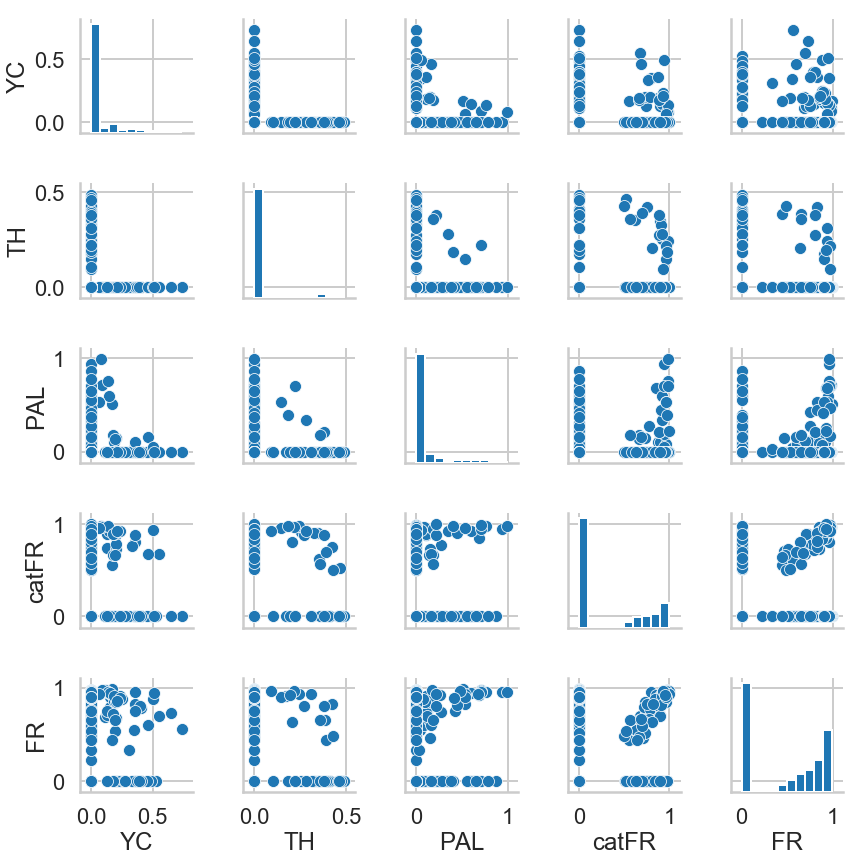

In [69]:
sns.pairplot(data=task_data.fillna(0), vars=['YC','TH','PAL','catFR','FR'])

In [70]:
# add averages over recal and nav tasks
task_data = task_data.assign(recall = task_data[['catFR','FR','PAL']].mean(axis=1, skipna=True))
task_data = task_data.assign(nav = task_data[['TH','YC']].mean(axis=1, skipna=True))
task_data = task_data.assign(scale_nav =  1 - task_data['nav'])
task_data = task_data.assign(avg = task_data[['scale_nav','recall']].mean(axis=1, skipna=True))
task_data.head()

subj        YC  TH       PAL  catFR        FR    recall       nav  \
0  R1001P  0.345526 NaN  0.041370    NaN  0.546573  0.293972  0.345526   
1  R1002P       NaN NaN  0.492335    NaN  0.945857  0.719096       NaN   
2  R1003P       NaN NaN  0.083711    NaN  0.602817  0.343264       NaN   
3  R1004D       NaN NaN       NaN  0.625       NaN  0.625000       NaN   
4  R1006P  0.401778 NaN       NaN    NaN  0.779412  0.779412  0.401778   

   scale_nav       avg  
0   0.654474  0.474223  
1        NaN  0.719096  
2        NaN  0.343264  
3        NaN  0.625000  
4   0.598222  0.688817

In [71]:
# count missing values again
task_data.apply(lambda x: sum(x.isnull())/x.size*100, axis=0)

subj          0.000000
YC           78.597786
TH           86.715867
PAL          76.014760
catFR        62.730627
FR           40.959410
recall       18.819188
nav          65.313653
scale_nav    65.313653
avg           8.487085
dtype: float64

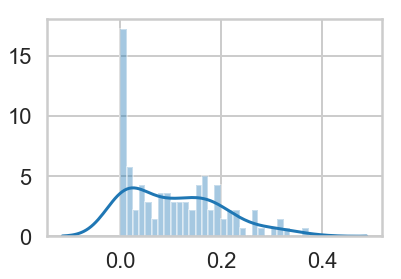

In [72]:
# Are subjects variable across tasks? 
var = pd.core.nanops.nanvar(task_data[['TH', 'YC', 'PAL', 'FR', 'catFR']], axis=1)
var = var[task_data[['TH', 'YC', 'PAL', 'FR', 'catFR']].isna().sum(axis=1) <= 3]
sns.distplot(var, bins=30)

In [73]:
# merge with net_data
subj_idx = [x in net_data.subj.unique() for x in task_data.subj]
task_data = task_data[subj_idx]
net_data = pd.merge(net_data, task_data, on=['subj'], how = 'outer')
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4890 entries, 0 to 4889
Data columns (total 66 columns):
band_measure              4890 non-null object
n_tp                      4890 non-null int64
str_beta_bin              4769 non-null float64
str_beta_num              4791 non-null float64
str_beta_spr              4770 non-null float64
ti_beta_bin               4772 non-null float64
ti_beta_num               4794 non-null float64
ti_beta_spr               4784 non-null float64
str_soz_beta_bin          3319 non-null float64
str_soz_beta_num          3319 non-null float64
str_soz_beta_spr          3333 non-null float64
str_not_soz_beta_num      3323 non-null float64
str_spike_beta_num        3199 non-null float64
str_not_soz_beta_spr      3319 non-null float64
str_not_soz_beta_bin      3307 non-null float64
str_spike_beta_bin        3199 non-null float64
str_spike_beta_spr        3211 non-null float64
str_not_spike_beta_bin    3188 non-null float64
Measure                   4890 n

In [74]:
net_data.subj.nunique()

142

In [75]:
# save
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_task_data_clean{detector}.csv')

## Demographics

In [76]:
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4890 entries, 0 to 4889
Data columns (total 66 columns):
band_measure              4890 non-null object
n_tp                      4890 non-null int64
str_beta_bin              4769 non-null float64
str_beta_num              4791 non-null float64
str_beta_spr              4770 non-null float64
ti_beta_bin               4772 non-null float64
ti_beta_num               4794 non-null float64
ti_beta_spr               4784 non-null float64
str_soz_beta_bin          3319 non-null float64
str_soz_beta_num          3319 non-null float64
str_soz_beta_spr          3333 non-null float64
str_not_soz_beta_num      3323 non-null float64
str_spike_beta_num        3199 non-null float64
str_not_soz_beta_spr      3319 non-null float64
str_not_soz_beta_bin      3307 non-null float64
str_spike_beta_bin        3199 non-null float64
str_spike_beta_spr        3211 non-null float64
str_not_spike_beta_bin    3188 non-null float64
Measure                   4890 n

In [77]:
# add institution
def get_inst(subj):
    if subj[-1] == 'J':
        net_data[net_data['subj'] == subj]['Institution'] = 'Jeff'
    elif subj[-1] == 'P':
        net_data[net_data['subj'] == subj]['Institution'] = 'Penn'
    elif subj[-1] == 'M':
        net_data[net_data['subj'] == subj]['Institution'] = 'Mayo'
    elif subj[-1] == 'C':
        net_data[net_data['subj'] == subj]['Institution'] = 'Columbia'
    elif subj[-1] == 'E':
        net_data[net_data['subj'] == subj]['Institution'] = 'Emory'
    elif subj[-1] == 'D':
        net_data[net_data['subj'] == subj]['Institution'] = 'Dartmouth'
    elif subj[-1] == 'N':
        net_data[net_data['subj'] == subj]['Institution'] = 'NINDS'
    else:
        net_data.loc[net_data['subj'] == subj,'Institution'] = subj[-1]
        
for s in net_data[net_data['Institution'].isna()]['subj'].values:
    get_inst(s)

In [78]:
sum(net_data['Institution'].isna())

0

In [79]:
# replace empty strnigs with nans
net_data = net_data.replace(r'^\s*$', np.nan, regex=True)

In [80]:
print('Etiology: ' + str(net_data[[not x for x in net_data['Etiology'].isna()]]['subj'].nunique()/net_data.subj.nunique()))
print('Education: ' + str(net_data[[not x for x in net_data['Education'].isna()]]['subj'].nunique()/net_data.subj.nunique()))
print('Institution: ' + str(net_data[[not x for x in net_data['Institution'].isna()]]['subj'].nunique()/net_data.subj.nunique()))
print('Lesional: ' + str(net_data[[not x for x in net_data['Lesional'].isna()]]['subj'].nunique()/net_data.subj.nunique()))
print('SeizureAge: ' + str(net_data[[not x for x in net_data['SeizureAge'].isna()]]['subj'].nunique()/net_data.subj.nunique()))
print('locus: ' + str(net_data[[not x for x in net_data['locus'].isna()]]['subj'].nunique()/net_data.subj.nunique()))
print('hem: ' + str(net_data[[not x for x in net_data['hem'].isna()]]['subj'].nunique()/net_data.subj.nunique()))
print('avg: ' + str(net_data[[not x for x in net_data['avg'].isna()]]['subj'].nunique()/net_data.subj.nunique()))


Etiology: 0.7887323943661971
Education: 0.6408450704225352
Institution: 1.0
Lesional: 0.8661971830985915
SeizureAge: 0.8380281690140845
locus: 0.7535211267605634
hem: 0.7535211267605634
avg: 0.971830985915493


In [81]:
# add most common etiology (unkown) and education to missing data
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4890 entries, 0 to 4889
Data columns (total 66 columns):
band_measure              4890 non-null object
n_tp                      4890 non-null int64
str_beta_bin              4769 non-null float64
str_beta_num              4791 non-null float64
str_beta_spr              4770 non-null float64
ti_beta_bin               4772 non-null float64
ti_beta_num               4794 non-null float64
ti_beta_spr               4784 non-null float64
str_soz_beta_bin          3319 non-null float64
str_soz_beta_num          3319 non-null float64
str_soz_beta_spr          3333 non-null float64
str_not_soz_beta_num      3323 non-null float64
str_spike_beta_num        3199 non-null float64
str_not_soz_beta_spr      3319 non-null float64
str_not_soz_beta_bin      3307 non-null float64
str_spike_beta_bin        3199 non-null float64
str_spike_beta_spr        3211 non-null float64
str_not_spike_beta_bin    3188 non-null float64
Measure                   4890 n

In [82]:
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_dem_data{detector}.csv')

In [83]:
net_data.subj.nunique()

142